In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# Load the feature selection results
fs_type = 'full'

In [4]:
# Parameters
fs_type = "uni95"


In [5]:
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 396
Categorical features: 10
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=False if fs_type=="full" else True,
    include_text_features=False,
)

text_cols = list()

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 468
Categorical Columns: 10


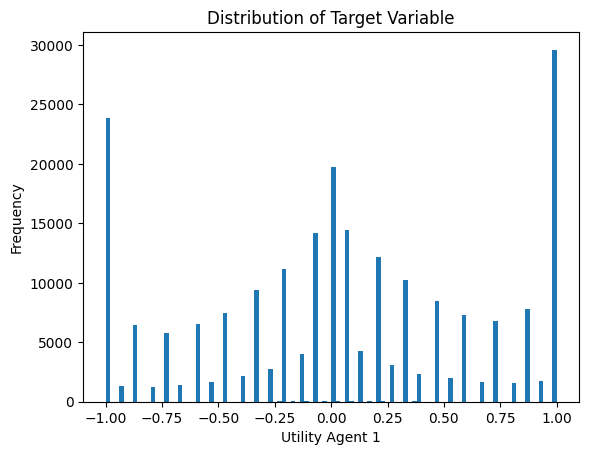

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model

In [9]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters for CatBoost
    params = {

        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        'bagging_temperature' : 0.50,

        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }


        # # Text processing parameters to mimic TF-IDF
        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'separator_type': 'ByDelimiter',
        #     'delimiter': ' '
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'NgramDict',
        #     'max_dictionary_size': '500',  # Match max_features=500
        #     'occurrence_lower_bound': '3',
        #     'gram_order': '3',  # Maximum n-gram size
        #     'min_gram_order': '2'  # Minimum n-gram size
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',  # Most similar to TF-IDF
        #     'dictionary_id': 'NgramDict'
        # }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            # data=X_train[numerical_cols + categorical_cols + text_cols],
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        val_pool = cb.Pool(
            # data=X_valid[numerical_cols + categorical_cols + text_cols],
            data=X_valid[numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        feat_importance = feat_importance.rename(columns={'importance': f'importance_f{fold}'})
        feat_importance_dfs.append(feat_importance)
        plot_feature_importance(feat_importance.rename(columns={f'importance_f{fold}': 'importance'}))
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

Fold 1


0:	learn: 0.6132016	test: 0.5496333	best: 0.5496333 (0)	total: 183ms	remaining: 9m 9s


50:	learn: 0.3819087	test: 0.4609366	best: 0.4609366 (50)	total: 6.61s	remaining: 6m 21s


100:	learn: 0.3436891	test: 0.4437776	best: 0.4437776 (100)	total: 13.5s	remaining: 6m 27s


150:	learn: 0.3199030	test: 0.4351146	best: 0.4351146 (150)	total: 20.3s	remaining: 6m 22s


200:	learn: 0.3051638	test: 0.4308986	best: 0.4308986 (200)	total: 27.1s	remaining: 6m 16s


250:	learn: 0.2927078	test: 0.4283098	best: 0.4283098 (250)	total: 33.8s	remaining: 6m 9s


300:	learn: 0.2826948	test: 0.4265041	best: 0.4265041 (300)	total: 40.5s	remaining: 6m 3s


350:	learn: 0.2749017	test: 0.4246005	best: 0.4245788 (349)	total: 47.3s	remaining: 5m 57s


400:	learn: 0.2685687	test: 0.4234537	best: 0.4234358 (399)	total: 54.2s	remaining: 5m 51s


450:	learn: 0.2625535	test: 0.4227008	best: 0.4227008 (450)	total: 1m 1s	remaining: 5m 45s


500:	learn: 0.2572610	test: 0.4218553	best: 0.4218471 (498)	total: 1m 7s	remaining: 5m 38s


550:	learn: 0.2525584	test: 0.4213864	best: 0.4213864 (550)	total: 1m 14s	remaining: 5m 31s


600:	learn: 0.2479835	test: 0.4208025	best: 0.4207906 (599)	total: 1m 21s	remaining: 5m 25s


650:	learn: 0.2436693	test: 0.4204025	best: 0.4203851 (645)	total: 1m 28s	remaining: 5m 18s


700:	learn: 0.2401851	test: 0.4199152	best: 0.4199152 (700)	total: 1m 35s	remaining: 5m 12s


750:	learn: 0.2364417	test: 0.4198486	best: 0.4198397 (749)	total: 1m 41s	remaining: 5m 5s


800:	learn: 0.2334547	test: 0.4195404	best: 0.4195216 (798)	total: 1m 48s	remaining: 4m 58s


850:	learn: 0.2304060	test: 0.4192944	best: 0.4192656 (845)	total: 1m 55s	remaining: 4m 51s


900:	learn: 0.2275464	test: 0.4189344	best: 0.4189204 (899)	total: 2m 2s	remaining: 4m 45s


950:	learn: 0.2250110	test: 0.4188635	best: 0.4188059 (912)	total: 2m 9s	remaining: 4m 38s


1000:	learn: 0.2225783	test: 0.4185094	best: 0.4185037 (999)	total: 2m 16s	remaining: 4m 31s


1050:	learn: 0.2201665	test: 0.4184235	best: 0.4184235 (1050)	total: 2m 23s	remaining: 4m 25s


1100:	learn: 0.2178595	test: 0.4182414	best: 0.4182250 (1098)	total: 2m 30s	remaining: 4m 18s


1150:	learn: 0.2156024	test: 0.4180904	best: 0.4180863 (1147)	total: 2m 36s	remaining: 4m 12s


1200:	learn: 0.2134886	test: 0.4179412	best: 0.4179360 (1198)	total: 2m 43s	remaining: 4m 5s


1250:	learn: 0.2113827	test: 0.4178685	best: 0.4178254 (1232)	total: 2m 50s	remaining: 3m 58s


1300:	learn: 0.2093253	test: 0.4176932	best: 0.4176657 (1289)	total: 2m 57s	remaining: 3m 51s


1350:	learn: 0.2073811	test: 0.4176345	best: 0.4176244 (1348)	total: 3m 4s	remaining: 3m 45s


1400:	learn: 0.2056072	test: 0.4174949	best: 0.4174949 (1400)	total: 3m 11s	remaining: 3m 38s


1450:	learn: 0.2037993	test: 0.4173601	best: 0.4173601 (1450)	total: 3m 18s	remaining: 3m 31s


1500:	learn: 0.2019253	test: 0.4174386	best: 0.4173497 (1451)	total: 3m 25s	remaining: 3m 24s


1550:	learn: 0.2000235	test: 0.4173523	best: 0.4173363 (1543)	total: 3m 31s	remaining: 3m 18s


1600:	learn: 0.1984173	test: 0.4173078	best: 0.4172931 (1586)	total: 3m 38s	remaining: 3m 11s


1650:	learn: 0.1965881	test: 0.4172429	best: 0.4172423 (1648)	total: 3m 45s	remaining: 3m 4s


1700:	learn: 0.1950297	test: 0.4172235	best: 0.4172062 (1655)	total: 3m 52s	remaining: 2m 57s


1750:	learn: 0.1934480	test: 0.4171676	best: 0.4171675 (1749)	total: 3m 59s	remaining: 2m 50s


1800:	learn: 0.1919460	test: 0.4171427	best: 0.4171301 (1796)	total: 4m 6s	remaining: 2m 44s


1850:	learn: 0.1905279	test: 0.4171172	best: 0.4171111 (1842)	total: 4m 13s	remaining: 2m 37s


1900:	learn: 0.1889958	test: 0.4172601	best: 0.4171111 (1842)	total: 4m 20s	remaining: 2m 30s


1950:	learn: 0.1875694	test: 0.4172753	best: 0.4171111 (1842)	total: 4m 27s	remaining: 2m 23s


2000:	learn: 0.1862395	test: 0.4171269	best: 0.4171111 (1842)	total: 4m 34s	remaining: 2m 16s


2050:	learn: 0.1847991	test: 0.4171579	best: 0.4170926 (2010)	total: 4m 40s	remaining: 2m 9s


2100:	learn: 0.1835085	test: 0.4171227	best: 0.4170558 (2066)	total: 4m 47s	remaining: 2m 3s


2150:	learn: 0.1820501	test: 0.4169885	best: 0.4169885 (2150)	total: 4m 54s	remaining: 1m 56s


2200:	learn: 0.1806958	test: 0.4169343	best: 0.4169231 (2194)	total: 5m 1s	remaining: 1m 49s


2250:	learn: 0.1794217	test: 0.4170402	best: 0.4169231 (2194)	total: 5m 8s	remaining: 1m 42s


2300:	learn: 0.1782474	test: 0.4169766	best: 0.4169231 (2194)	total: 5m 15s	remaining: 1m 35s


2350:	learn: 0.1769554	test: 0.4169551	best: 0.4169231 (2194)	total: 5m 23s	remaining: 1m 29s


2400:	learn: 0.1757705	test: 0.4169860	best: 0.4169231 (2194)	total: 5m 30s	remaining: 1m 22s


2450:	learn: 0.1745000	test: 0.4169698	best: 0.4169231 (2194)	total: 5m 37s	remaining: 1m 15s


2500:	learn: 0.1732402	test: 0.4168663	best: 0.4168663 (2500)	total: 5m 44s	remaining: 1m 8s


2550:	learn: 0.1720700	test: 0.4168582	best: 0.4168290 (2520)	total: 5m 51s	remaining: 1m 1s


2600:	learn: 0.1709209	test: 0.4168831	best: 0.4168290 (2520)	total: 5m 58s	remaining: 55s


2650:	learn: 0.1697694	test: 0.4169582	best: 0.4168290 (2520)	total: 6m 5s	remaining: 48.1s


2700:	learn: 0.1687151	test: 0.4169640	best: 0.4168290 (2520)	total: 6m 12s	remaining: 41.3s


2750:	learn: 0.1676760	test: 0.4169556	best: 0.4168290 (2520)	total: 6m 19s	remaining: 34.4s


2800:	learn: 0.1666133	test: 0.4169801	best: 0.4168290 (2520)	total: 6m 27s	remaining: 27.5s


2850:	learn: 0.1655620	test: 0.4170408	best: 0.4168290 (2520)	total: 6m 34s	remaining: 20.6s


2900:	learn: 0.1644400	test: 0.4170463	best: 0.4168290 (2520)	total: 6m 40s	remaining: 13.7s


2950:	learn: 0.1634584	test: 0.4170622	best: 0.4168290 (2520)	total: 6m 48s	remaining: 6.78s


2999:	learn: 0.1624590	test: 0.4170283	best: 0.4168290 (2520)	total: 6m 54s	remaining: 0us

bestTest = 0.4168289865
bestIteration = 2520

Shrink model to first 2521 iterations.


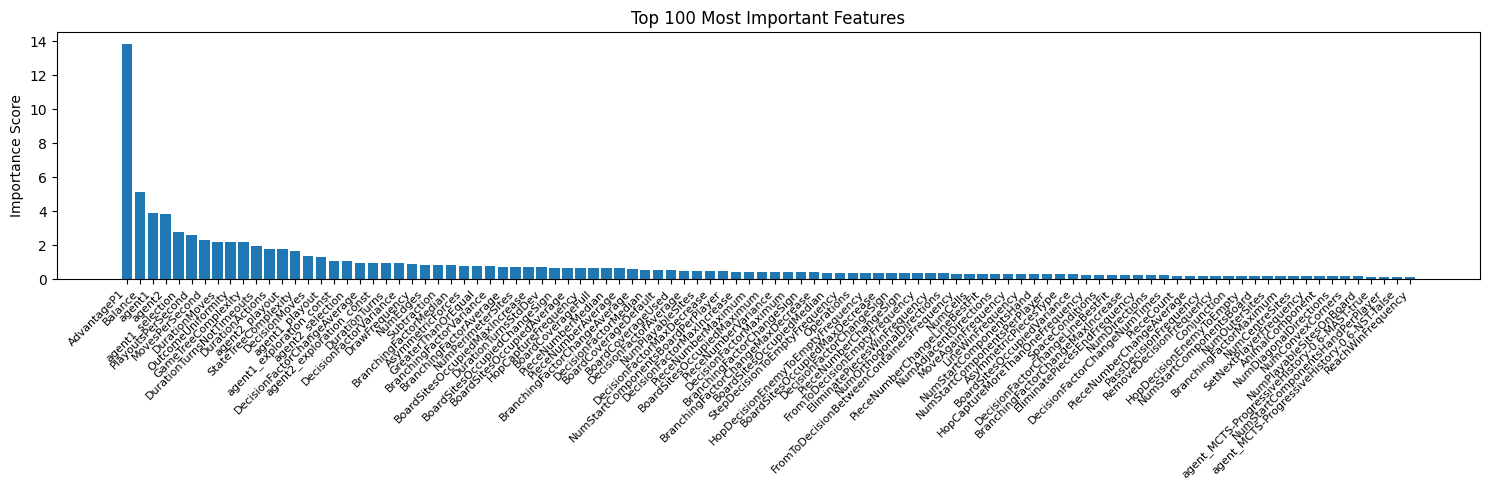

Fold 1 - RMSE: 0.4164260903157605
Fold 2


0:	learn: 0.6047939	test: 0.5801584	best: 0.5801584 (0)	total: 122ms	remaining: 6m 5s


50:	learn: 0.3868828	test: 0.4756571	best: 0.4756571 (50)	total: 7s	remaining: 6m 44s


100:	learn: 0.3477039	test: 0.4594621	best: 0.4594621 (100)	total: 14.3s	remaining: 6m 49s


150:	learn: 0.3267619	test: 0.4546355	best: 0.4546309 (149)	total: 21.5s	remaining: 6m 44s


200:	learn: 0.3111311	test: 0.4517924	best: 0.4517924 (200)	total: 28.7s	remaining: 6m 40s


250:	learn: 0.2994556	test: 0.4496662	best: 0.4496138 (249)	total: 36.1s	remaining: 6m 34s


300:	learn: 0.2897601	test: 0.4479761	best: 0.4479623 (298)	total: 43.6s	remaining: 6m 31s


350:	learn: 0.2813945	test: 0.4465622	best: 0.4465622 (350)	total: 50.9s	remaining: 6m 24s


400:	learn: 0.2750396	test: 0.4457638	best: 0.4457638 (400)	total: 58.2s	remaining: 6m 16s


450:	learn: 0.2690389	test: 0.4449100	best: 0.4449100 (450)	total: 1m 5s	remaining: 6m 9s


500:	learn: 0.2631872	test: 0.4445267	best: 0.4445178 (466)	total: 1m 12s	remaining: 6m 1s


550:	learn: 0.2586795	test: 0.4439368	best: 0.4439368 (550)	total: 1m 19s	remaining: 5m 54s


600:	learn: 0.2544393	test: 0.4438319	best: 0.4438319 (600)	total: 1m 27s	remaining: 5m 47s


650:	learn: 0.2503038	test: 0.4432155	best: 0.4432155 (650)	total: 1m 34s	remaining: 5m 40s


700:	learn: 0.2464741	test: 0.4426398	best: 0.4426214 (694)	total: 1m 41s	remaining: 5m 33s


750:	learn: 0.2430510	test: 0.4425610	best: 0.4424320 (737)	total: 1m 48s	remaining: 5m 25s


800:	learn: 0.2397927	test: 0.4419952	best: 0.4419952 (800)	total: 1m 55s	remaining: 5m 18s


850:	learn: 0.2368099	test: 0.4416410	best: 0.4416410 (850)	total: 2m 3s	remaining: 5m 10s


900:	learn: 0.2339815	test: 0.4415034	best: 0.4414753 (896)	total: 2m 10s	remaining: 5m 3s


950:	learn: 0.2310411	test: 0.4412415	best: 0.4412276 (939)	total: 2m 17s	remaining: 4m 56s


1000:	learn: 0.2284616	test: 0.4411171	best: 0.4410938 (997)	total: 2m 24s	remaining: 4m 48s


1050:	learn: 0.2259570	test: 0.4408476	best: 0.4408432 (1046)	total: 2m 31s	remaining: 4m 41s


1100:	learn: 0.2236168	test: 0.4407358	best: 0.4407286 (1086)	total: 2m 39s	remaining: 4m 34s


1150:	learn: 0.2213847	test: 0.4407518	best: 0.4407237 (1105)	total: 2m 46s	remaining: 4m 27s


1200:	learn: 0.2190403	test: 0.4404117	best: 0.4404078 (1199)	total: 2m 53s	remaining: 4m 20s


1250:	learn: 0.2171256	test: 0.4403692	best: 0.4403343 (1249)	total: 3m	remaining: 4m 12s


1300:	learn: 0.2153291	test: 0.4402784	best: 0.4402784 (1300)	total: 3m 7s	remaining: 4m 5s


1350:	learn: 0.2132682	test: 0.4401399	best: 0.4401238 (1339)	total: 3m 15s	remaining: 3m 58s


1400:	learn: 0.2114361	test: 0.4399580	best: 0.4399580 (1400)	total: 3m 22s	remaining: 3m 51s


1450:	learn: 0.2096283	test: 0.4398920	best: 0.4398474 (1437)	total: 3m 29s	remaining: 3m 43s


1500:	learn: 0.2080117	test: 0.4396935	best: 0.4396935 (1500)	total: 3m 36s	remaining: 3m 36s


1550:	learn: 0.2063734	test: 0.4395794	best: 0.4395651 (1547)	total: 3m 44s	remaining: 3m 29s


1600:	learn: 0.2046386	test: 0.4395272	best: 0.4394782 (1579)	total: 3m 51s	remaining: 3m 22s


1650:	learn: 0.2026875	test: 0.4395028	best: 0.4394588 (1620)	total: 3m 58s	remaining: 3m 15s


1700:	learn: 0.2011810	test: 0.4394594	best: 0.4394513 (1698)	total: 4m 6s	remaining: 3m 7s


1750:	learn: 0.1995691	test: 0.4394156	best: 0.4394064 (1744)	total: 4m 13s	remaining: 3m


1800:	learn: 0.1980955	test: 0.4394181	best: 0.4394064 (1744)	total: 4m 20s	remaining: 2m 53s


1850:	learn: 0.1966768	test: 0.4394789	best: 0.4394064 (1744)	total: 4m 27s	remaining: 2m 46s


1900:	learn: 0.1951230	test: 0.4393571	best: 0.4393283 (1899)	total: 4m 35s	remaining: 2m 39s


1950:	learn: 0.1937356	test: 0.4394348	best: 0.4393283 (1899)	total: 4m 42s	remaining: 2m 31s


2000:	learn: 0.1922376	test: 0.4393765	best: 0.4393283 (1899)	total: 4m 49s	remaining: 2m 24s


2050:	learn: 0.1908464	test: 0.4395241	best: 0.4393283 (1899)	total: 4m 57s	remaining: 2m 17s


2100:	learn: 0.1893642	test: 0.4395424	best: 0.4393283 (1899)	total: 5m 4s	remaining: 2m 10s


2150:	learn: 0.1880444	test: 0.4395283	best: 0.4393283 (1899)	total: 5m 11s	remaining: 2m 2s


2200:	learn: 0.1866923	test: 0.4394128	best: 0.4393283 (1899)	total: 5m 18s	remaining: 1m 55s


2250:	learn: 0.1852246	test: 0.4394007	best: 0.4393283 (1899)	total: 5m 25s	remaining: 1m 48s


2300:	learn: 0.1838792	test: 0.4394444	best: 0.4393283 (1899)	total: 5m 33s	remaining: 1m 41s


2350:	learn: 0.1826817	test: 0.4394509	best: 0.4393283 (1899)	total: 5m 40s	remaining: 1m 33s


2400:	learn: 0.1813368	test: 0.4393201	best: 0.4393201 (2399)	total: 5m 47s	remaining: 1m 26s


2450:	learn: 0.1801736	test: 0.4392910	best: 0.4392845 (2447)	total: 5m 54s	remaining: 1m 19s


2500:	learn: 0.1789597	test: 0.4392989	best: 0.4392069 (2469)	total: 6m 1s	remaining: 1m 12s


2550:	learn: 0.1778367	test: 0.4393196	best: 0.4392069 (2469)	total: 6m 8s	remaining: 1m 4s


2600:	learn: 0.1765776	test: 0.4392422	best: 0.4392069 (2469)	total: 6m 15s	remaining: 57.7s


2650:	learn: 0.1755271	test: 0.4392009	best: 0.4391863 (2644)	total: 6m 23s	remaining: 50.4s


2700:	learn: 0.1744587	test: 0.4391711	best: 0.4391711 (2700)	total: 6m 30s	remaining: 43.2s


2750:	learn: 0.1733443	test: 0.4392182	best: 0.4391692 (2701)	total: 6m 37s	remaining: 36s


2800:	learn: 0.1722746	test: 0.4391752	best: 0.4391692 (2701)	total: 6m 44s	remaining: 28.7s


2850:	learn: 0.1711306	test: 0.4390732	best: 0.4390732 (2850)	total: 6m 51s	remaining: 21.5s


2900:	learn: 0.1700254	test: 0.4391384	best: 0.4390732 (2850)	total: 6m 58s	remaining: 14.3s


2950:	learn: 0.1689865	test: 0.4391380	best: 0.4390732 (2850)	total: 7m 5s	remaining: 7.07s


2999:	learn: 0.1679013	test: 0.4391610	best: 0.4390732 (2850)	total: 7m 13s	remaining: 0us

bestTest = 0.4390732334
bestIteration = 2850

Shrink model to first 2851 iterations.


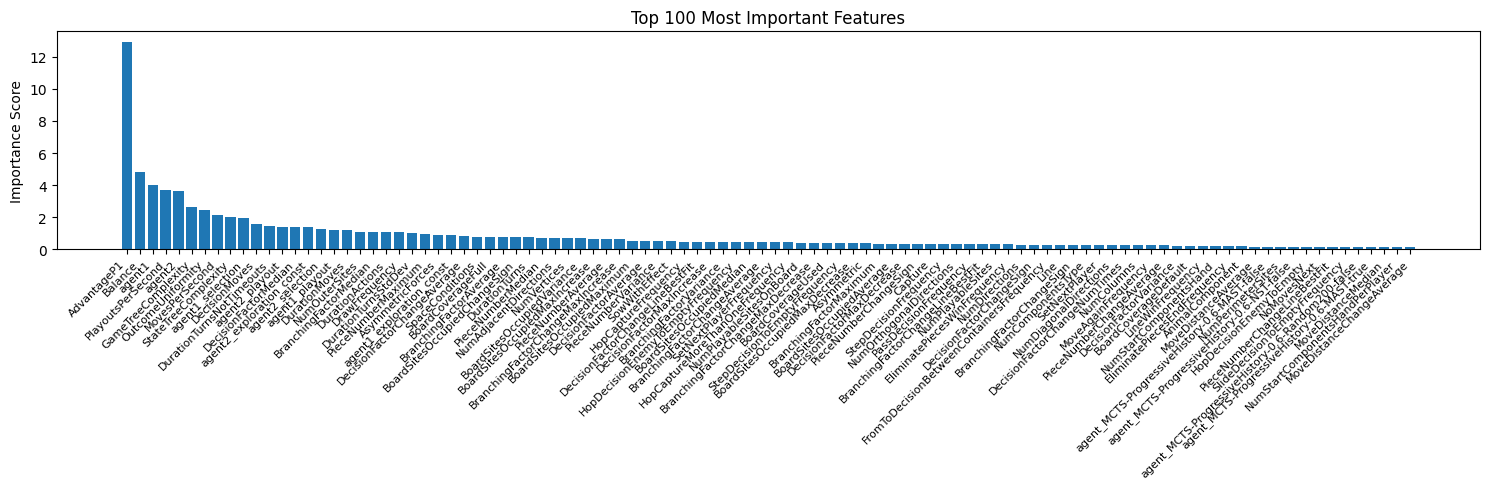

Fold 2 - RMSE: 0.43853528177417755
Fold 3


0:	learn: 0.6023051	test: 0.5982809	best: 0.5982809 (0)	total: 112ms	remaining: 5m 37s


50:	learn: 0.3891453	test: 0.4707648	best: 0.4707648 (50)	total: 6.83s	remaining: 6m 35s


100:	learn: 0.3522496	test: 0.4578112	best: 0.4578112 (100)	total: 14s	remaining: 6m 43s


150:	learn: 0.3297492	test: 0.4510804	best: 0.4510804 (150)	total: 21.1s	remaining: 6m 38s


200:	learn: 0.3129311	test: 0.4453336	best: 0.4453199 (199)	total: 28.1s	remaining: 6m 31s


250:	learn: 0.3010265	test: 0.4425825	best: 0.4425332 (249)	total: 35.2s	remaining: 6m 25s


300:	learn: 0.2904584	test: 0.4406691	best: 0.4405745 (298)	total: 42.2s	remaining: 6m 18s


350:	learn: 0.2822227	test: 0.4391444	best: 0.4391443 (347)	total: 49.2s	remaining: 6m 11s


400:	learn: 0.2755531	test: 0.4382628	best: 0.4382376 (399)	total: 56.2s	remaining: 6m 4s


450:	learn: 0.2697335	test: 0.4370748	best: 0.4370748 (450)	total: 1m 3s	remaining: 5m 57s


500:	learn: 0.2641420	test: 0.4359726	best: 0.4359726 (500)	total: 1m 10s	remaining: 5m 50s


550:	learn: 0.2592323	test: 0.4355277	best: 0.4355201 (543)	total: 1m 17s	remaining: 5m 44s


600:	learn: 0.2549343	test: 0.4349933	best: 0.4349933 (600)	total: 1m 24s	remaining: 5m 37s


650:	learn: 0.2506417	test: 0.4345955	best: 0.4345955 (650)	total: 1m 31s	remaining: 5m 30s


700:	learn: 0.2466092	test: 0.4344615	best: 0.4343576 (681)	total: 1m 38s	remaining: 5m 23s


750:	learn: 0.2433113	test: 0.4342222	best: 0.4341539 (748)	total: 1m 45s	remaining: 5m 16s


800:	learn: 0.2398616	test: 0.4340983	best: 0.4340766 (796)	total: 1m 52s	remaining: 5m 9s


850:	learn: 0.2366154	test: 0.4337622	best: 0.4337314 (845)	total: 2m	remaining: 5m 3s


900:	learn: 0.2334750	test: 0.4335948	best: 0.4335567 (898)	total: 2m 7s	remaining: 4m 56s


950:	learn: 0.2306016	test: 0.4332364	best: 0.4332364 (950)	total: 2m 14s	remaining: 4m 49s


1000:	learn: 0.2280898	test: 0.4331574	best: 0.4330997 (985)	total: 2m 21s	remaining: 4m 42s


1050:	learn: 0.2255596	test: 0.4330409	best: 0.4330248 (1045)	total: 2m 28s	remaining: 4m 35s


1100:	learn: 0.2230180	test: 0.4327868	best: 0.4327389 (1085)	total: 2m 35s	remaining: 4m 28s


1150:	learn: 0.2208904	test: 0.4326862	best: 0.4326702 (1139)	total: 2m 42s	remaining: 4m 21s


1200:	learn: 0.2189324	test: 0.4325548	best: 0.4325548 (1200)	total: 2m 50s	remaining: 4m 14s


1250:	learn: 0.2169036	test: 0.4322307	best: 0.4322214 (1246)	total: 2m 57s	remaining: 4m 7s


1300:	learn: 0.2148972	test: 0.4321475	best: 0.4321475 (1300)	total: 3m 4s	remaining: 4m


1350:	learn: 0.2130233	test: 0.4319729	best: 0.4319569 (1345)	total: 3m 11s	remaining: 3m 53s


1400:	learn: 0.2109684	test: 0.4319292	best: 0.4319292 (1400)	total: 3m 18s	remaining: 3m 46s


1450:	learn: 0.2090930	test: 0.4318304	best: 0.4318304 (1450)	total: 3m 25s	remaining: 3m 39s


1500:	learn: 0.2072395	test: 0.4318894	best: 0.4318248 (1452)	total: 3m 32s	remaining: 3m 32s


1550:	learn: 0.2052994	test: 0.4317127	best: 0.4317127 (1550)	total: 3m 39s	remaining: 3m 25s


1600:	learn: 0.2034297	test: 0.4315654	best: 0.4315654 (1600)	total: 3m 46s	remaining: 3m 18s


1650:	learn: 0.2018211	test: 0.4314891	best: 0.4314758 (1645)	total: 3m 53s	remaining: 3m 11s


1700:	learn: 0.2001521	test: 0.4314166	best: 0.4314127 (1699)	total: 4m	remaining: 3m 3s


1750:	learn: 0.1985656	test: 0.4313290	best: 0.4313290 (1750)	total: 4m 8s	remaining: 2m 56s


1800:	learn: 0.1969679	test: 0.4313620	best: 0.4313112 (1772)	total: 4m 15s	remaining: 2m 49s


1850:	learn: 0.1953885	test: 0.4312181	best: 0.4311911 (1847)	total: 4m 22s	remaining: 2m 42s


1900:	learn: 0.1939969	test: 0.4311510	best: 0.4311418 (1877)	total: 4m 29s	remaining: 2m 35s


1950:	learn: 0.1923186	test: 0.4309956	best: 0.4309956 (1950)	total: 4m 36s	remaining: 2m 28s


2000:	learn: 0.1908166	test: 0.4309470	best: 0.4309401 (1969)	total: 4m 43s	remaining: 2m 21s


2050:	learn: 0.1894035	test: 0.4309104	best: 0.4309104 (2050)	total: 4m 50s	remaining: 2m 14s


2100:	learn: 0.1880174	test: 0.4308028	best: 0.4307956 (2084)	total: 4m 57s	remaining: 2m 7s


2150:	learn: 0.1866698	test: 0.4307124	best: 0.4307124 (2150)	total: 5m 5s	remaining: 2m


2200:	learn: 0.1852095	test: 0.4306104	best: 0.4306104 (2200)	total: 5m 11s	remaining: 1m 53s


2250:	learn: 0.1838595	test: 0.4306131	best: 0.4305894 (2237)	total: 5m 19s	remaining: 1m 46s


2300:	learn: 0.1825348	test: 0.4305750	best: 0.4305520 (2285)	total: 5m 26s	remaining: 1m 39s


2350:	learn: 0.1813107	test: 0.4306231	best: 0.4305520 (2285)	total: 5m 33s	remaining: 1m 32s


2400:	learn: 0.1801354	test: 0.4305874	best: 0.4305520 (2285)	total: 5m 41s	remaining: 1m 25s


2450:	learn: 0.1789002	test: 0.4306397	best: 0.4305520 (2285)	total: 5m 48s	remaining: 1m 18s


2500:	learn: 0.1776548	test: 0.4305977	best: 0.4305520 (2285)	total: 5m 55s	remaining: 1m 10s


2550:	learn: 0.1764583	test: 0.4306067	best: 0.4305520 (2285)	total: 6m 2s	remaining: 1m 3s


2600:	learn: 0.1753193	test: 0.4305843	best: 0.4305520 (2285)	total: 6m 10s	remaining: 56.8s


2650:	learn: 0.1741977	test: 0.4306348	best: 0.4305520 (2285)	total: 6m 17s	remaining: 49.7s


2700:	learn: 0.1730563	test: 0.4306637	best: 0.4305520 (2285)	total: 6m 24s	remaining: 42.6s


2750:	learn: 0.1718076	test: 0.4306835	best: 0.4305520 (2285)	total: 6m 31s	remaining: 35.5s


2800:	learn: 0.1707209	test: 0.4306775	best: 0.4305520 (2285)	total: 6m 38s	remaining: 28.3s


2850:	learn: 0.1696894	test: 0.4305921	best: 0.4305520 (2285)	total: 6m 46s	remaining: 21.2s


2900:	learn: 0.1686949	test: 0.4305509	best: 0.4305509 (2900)	total: 6m 53s	remaining: 14.1s


2950:	learn: 0.1676352	test: 0.4306029	best: 0.4305481 (2901)	total: 7m	remaining: 6.98s


2999:	learn: 0.1665975	test: 0.4305832	best: 0.4305481 (2901)	total: 7m 7s	remaining: 0us

bestTest = 0.4305481116
bestIteration = 2901

Shrink model to first 2902 iterations.


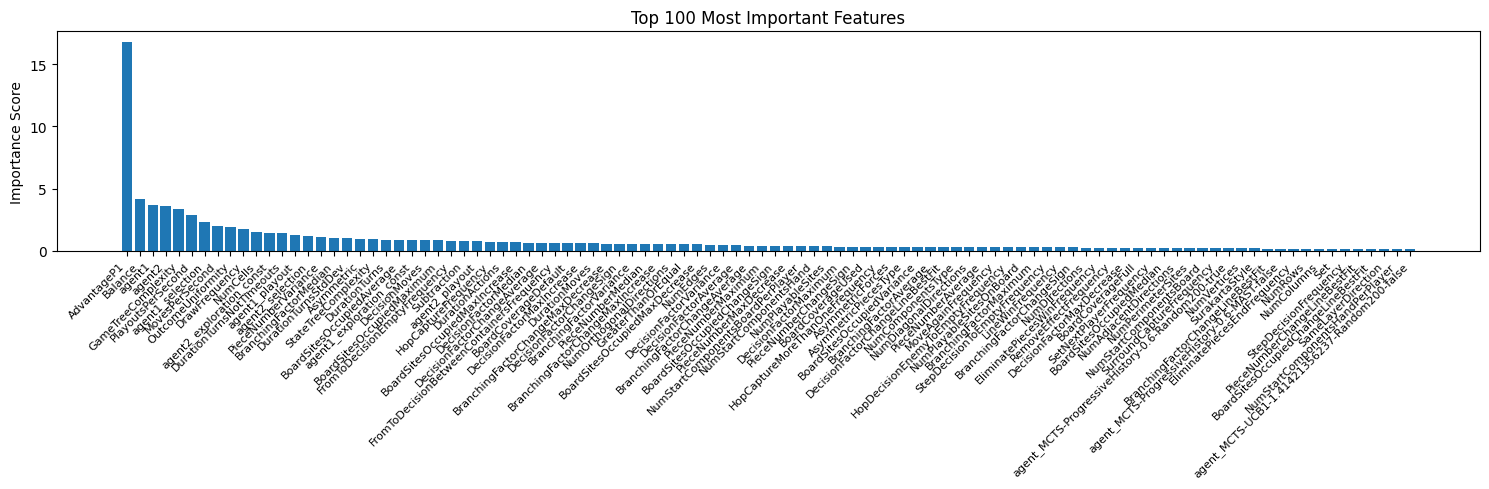

Fold 3 - RMSE: 0.4299982975946232
Fold 4


0:	learn: 0.6043903	test: 0.5887585	best: 0.5887585 (0)	total: 119ms	remaining: 5m 57s


50:	learn: 0.3848890	test: 0.4838033	best: 0.4838033 (50)	total: 7.06s	remaining: 6m 48s


100:	learn: 0.3481629	test: 0.4652987	best: 0.4652987 (100)	total: 14.1s	remaining: 6m 45s


150:	learn: 0.3255121	test: 0.4587376	best: 0.4587376 (150)	total: 21.1s	remaining: 6m 37s


200:	learn: 0.3097267	test: 0.4543818	best: 0.4542874 (198)	total: 28.1s	remaining: 6m 30s


250:	learn: 0.2968631	test: 0.4522624	best: 0.4522498 (249)	total: 35.1s	remaining: 6m 24s


300:	learn: 0.2873419	test: 0.4502105	best: 0.4501967 (299)	total: 42.1s	remaining: 6m 17s


350:	learn: 0.2794586	test: 0.4486988	best: 0.4486603 (345)	total: 49.1s	remaining: 6m 10s


400:	learn: 0.2727451	test: 0.4473320	best: 0.4473320 (400)	total: 56.2s	remaining: 6m 4s


450:	learn: 0.2667325	test: 0.4463020	best: 0.4463020 (450)	total: 1m 3s	remaining: 5m 57s


500:	learn: 0.2613219	test: 0.4454017	best: 0.4454017 (500)	total: 1m 10s	remaining: 5m 50s


550:	learn: 0.2562188	test: 0.4446925	best: 0.4446475 (544)	total: 1m 17s	remaining: 5m 43s


600:	learn: 0.2518306	test: 0.4439176	best: 0.4439014 (598)	total: 1m 24s	remaining: 5m 36s


650:	learn: 0.2469729	test: 0.4437145	best: 0.4436457 (649)	total: 1m 31s	remaining: 5m 29s


700:	learn: 0.2431170	test: 0.4433319	best: 0.4433319 (700)	total: 1m 38s	remaining: 5m 22s


750:	learn: 0.2396592	test: 0.4432099	best: 0.4431619 (723)	total: 1m 45s	remaining: 5m 16s


800:	learn: 0.2364484	test: 0.4430045	best: 0.4430045 (800)	total: 1m 52s	remaining: 5m 9s


850:	learn: 0.2333014	test: 0.4428247	best: 0.4428148 (849)	total: 1m 59s	remaining: 5m 2s


900:	learn: 0.2304887	test: 0.4425357	best: 0.4425144 (898)	total: 2m 6s	remaining: 4m 55s


950:	learn: 0.2278131	test: 0.4423809	best: 0.4423764 (948)	total: 2m 13s	remaining: 4m 48s


1000:	learn: 0.2251884	test: 0.4421805	best: 0.4421519 (994)	total: 2m 20s	remaining: 4m 41s


1050:	learn: 0.2228088	test: 0.4420304	best: 0.4419844 (1037)	total: 2m 27s	remaining: 4m 34s


1100:	learn: 0.2206442	test: 0.4419167	best: 0.4419167 (1100)	total: 2m 35s	remaining: 4m 27s


1150:	learn: 0.2182568	test: 0.4416737	best: 0.4416638 (1135)	total: 2m 42s	remaining: 4m 20s


1200:	learn: 0.2160020	test: 0.4417066	best: 0.4416638 (1135)	total: 2m 49s	remaining: 4m 13s


1250:	learn: 0.2138868	test: 0.4415890	best: 0.4415803 (1249)	total: 2m 56s	remaining: 4m 6s


1300:	learn: 0.2118079	test: 0.4414103	best: 0.4414103 (1300)	total: 3m 3s	remaining: 3m 59s


1350:	learn: 0.2099691	test: 0.4412813	best: 0.4412813 (1350)	total: 3m 10s	remaining: 3m 52s


1400:	learn: 0.2081366	test: 0.4412387	best: 0.4412281 (1390)	total: 3m 17s	remaining: 3m 45s


1450:	learn: 0.2063366	test: 0.4412454	best: 0.4411863 (1415)	total: 3m 24s	remaining: 3m 38s


1500:	learn: 0.2046811	test: 0.4411683	best: 0.4411683 (1500)	total: 3m 31s	remaining: 3m 31s


1550:	learn: 0.2028137	test: 0.4410358	best: 0.4410358 (1550)	total: 3m 38s	remaining: 3m 24s


1600:	learn: 0.2011740	test: 0.4409483	best: 0.4409375 (1588)	total: 3m 45s	remaining: 3m 17s


1650:	learn: 0.1996433	test: 0.4407981	best: 0.4407865 (1625)	total: 3m 52s	remaining: 3m 10s


1700:	learn: 0.1978934	test: 0.4407576	best: 0.4407507 (1697)	total: 3m 59s	remaining: 3m 3s


1750:	learn: 0.1963815	test: 0.4407115	best: 0.4407094 (1745)	total: 4m 6s	remaining: 2m 56s


1800:	learn: 0.1948995	test: 0.4405564	best: 0.4405502 (1788)	total: 4m 13s	remaining: 2m 49s


1850:	learn: 0.1934303	test: 0.4405811	best: 0.4405278 (1834)	total: 4m 20s	remaining: 2m 41s


1900:	learn: 0.1920504	test: 0.4405895	best: 0.4405278 (1834)	total: 4m 27s	remaining: 2m 34s


1950:	learn: 0.1906167	test: 0.4406377	best: 0.4405278 (1834)	total: 4m 35s	remaining: 2m 27s


2000:	learn: 0.1890494	test: 0.4405577	best: 0.4405278 (1834)	total: 4m 42s	remaining: 2m 20s


2050:	learn: 0.1877841	test: 0.4405581	best: 0.4405278 (1834)	total: 4m 49s	remaining: 2m 13s


2100:	learn: 0.1865394	test: 0.4405223	best: 0.4405188 (2092)	total: 4m 56s	remaining: 2m 6s


2150:	learn: 0.1851186	test: 0.4404920	best: 0.4404640 (2112)	total: 5m 3s	remaining: 1m 59s


2200:	learn: 0.1837693	test: 0.4403488	best: 0.4403488 (2200)	total: 5m 10s	remaining: 1m 52s


2250:	learn: 0.1824700	test: 0.4403684	best: 0.4403120 (2206)	total: 5m 17s	remaining: 1m 45s


2300:	learn: 0.1812566	test: 0.4403369	best: 0.4403120 (2206)	total: 5m 24s	remaining: 1m 38s


2350:	learn: 0.1800843	test: 0.4402450	best: 0.4402244 (2331)	total: 5m 32s	remaining: 1m 31s


2400:	learn: 0.1787813	test: 0.4401806	best: 0.4401759 (2398)	total: 5m 39s	remaining: 1m 24s


2450:	learn: 0.1776248	test: 0.4402227	best: 0.4401654 (2423)	total: 5m 46s	remaining: 1m 17s


2500:	learn: 0.1764437	test: 0.4402129	best: 0.4401654 (2423)	total: 5m 53s	remaining: 1m 10s


2550:	learn: 0.1753235	test: 0.4401956	best: 0.4401654 (2423)	total: 6m	remaining: 1m 3s


2600:	learn: 0.1742088	test: 0.4401766	best: 0.4401654 (2423)	total: 6m 7s	remaining: 56.4s


2650:	learn: 0.1731394	test: 0.4401710	best: 0.4401654 (2423)	total: 6m 15s	remaining: 49.4s


2700:	learn: 0.1720713	test: 0.4401726	best: 0.4401579 (2671)	total: 6m 22s	remaining: 42.3s


2750:	learn: 0.1709033	test: 0.4401517	best: 0.4401440 (2744)	total: 6m 29s	remaining: 35.2s


2800:	learn: 0.1698778	test: 0.4401477	best: 0.4401216 (2762)	total: 6m 36s	remaining: 28.2s


2850:	learn: 0.1688093	test: 0.4401295	best: 0.4401216 (2762)	total: 6m 43s	remaining: 21.1s


2900:	learn: 0.1677810	test: 0.4400873	best: 0.4400640 (2884)	total: 6m 51s	remaining: 14s


2950:	learn: 0.1665618	test: 0.4400700	best: 0.4400640 (2884)	total: 6m 58s	remaining: 6.94s


2999:	learn: 0.1655620	test: 0.4400815	best: 0.4400470 (2980)	total: 7m 5s	remaining: 0us

bestTest = 0.4400470283
bestIteration = 2980

Shrink model to first 2981 iterations.


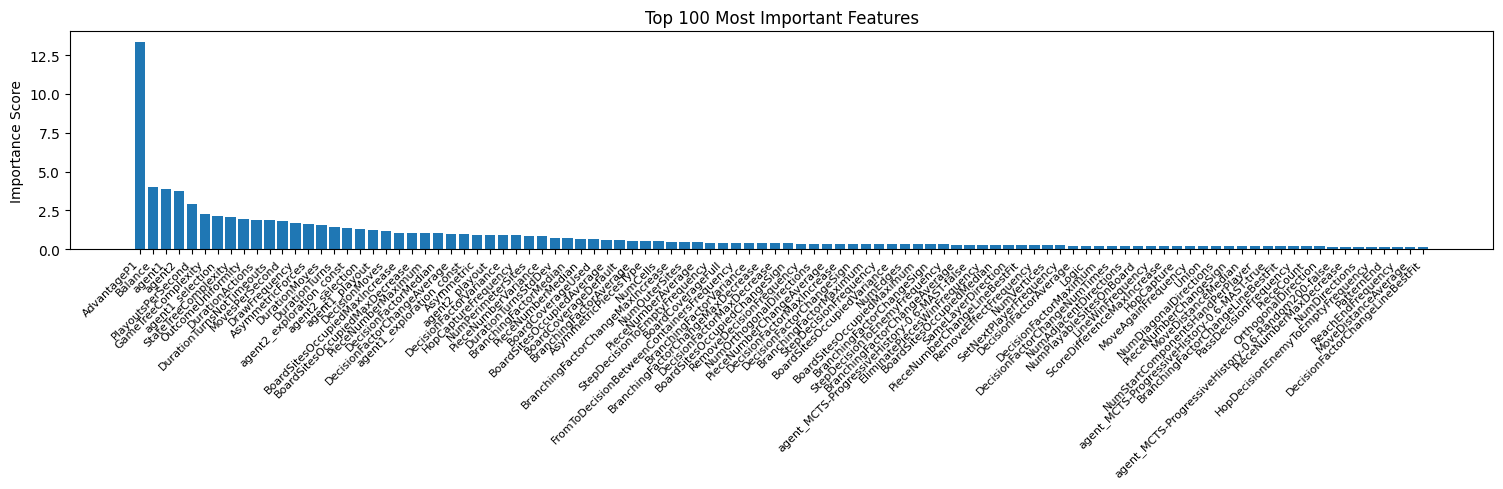

Fold 4 - RMSE: 0.4387775190054084
Fold 5


0:	learn: 0.6163194	test: 0.5437707	best: 0.5437707 (0)	total: 94.9ms	remaining: 4m 44s


50:	learn: 0.3958684	test: 0.4472980	best: 0.4472980 (50)	total: 6.64s	remaining: 6m 23s


100:	learn: 0.3566842	test: 0.4277513	best: 0.4277513 (100)	total: 13.6s	remaining: 6m 29s


150:	learn: 0.3336909	test: 0.4181703	best: 0.4181703 (150)	total: 20.4s	remaining: 6m 24s


200:	learn: 0.3162379	test: 0.4126128	best: 0.4126128 (200)	total: 27.2s	remaining: 6m 19s


250:	learn: 0.3038669	test: 0.4104472	best: 0.4104472 (250)	total: 34s	remaining: 6m 12s


300:	learn: 0.2939330	test: 0.4077909	best: 0.4077909 (300)	total: 40.9s	remaining: 6m 6s


350:	learn: 0.2858642	test: 0.4065457	best: 0.4065457 (350)	total: 47.8s	remaining: 6m


400:	learn: 0.2788045	test: 0.4054984	best: 0.4054072 (396)	total: 54.6s	remaining: 5m 54s


450:	learn: 0.2721284	test: 0.4048034	best: 0.4048034 (450)	total: 1m 1s	remaining: 5m 48s


500:	learn: 0.2665694	test: 0.4043145	best: 0.4043108 (497)	total: 1m 8s	remaining: 5m 41s


550:	learn: 0.2610000	test: 0.4034187	best: 0.4034187 (550)	total: 1m 15s	remaining: 5m 34s


600:	learn: 0.2562244	test: 0.4028370	best: 0.4028370 (600)	total: 1m 22s	remaining: 5m 28s


650:	learn: 0.2518758	test: 0.4025819	best: 0.4025678 (643)	total: 1m 29s	remaining: 5m 21s


700:	learn: 0.2484035	test: 0.4023504	best: 0.4023418 (698)	total: 1m 35s	remaining: 5m 14s


750:	learn: 0.2444223	test: 0.4023134	best: 0.4021856 (733)	total: 1m 42s	remaining: 5m 7s


800:	learn: 0.2412330	test: 0.4022047	best: 0.4021618 (779)	total: 1m 49s	remaining: 5m 1s


850:	learn: 0.2381078	test: 0.4020479	best: 0.4020306 (819)	total: 1m 56s	remaining: 4m 54s


900:	learn: 0.2350867	test: 0.4019265	best: 0.4018750 (899)	total: 2m 3s	remaining: 4m 47s


950:	learn: 0.2321307	test: 0.4017428	best: 0.4017253 (948)	total: 2m 10s	remaining: 4m 40s


1000:	learn: 0.2293183	test: 0.4017845	best: 0.4017253 (948)	total: 2m 17s	remaining: 4m 34s


1050:	learn: 0.2268853	test: 0.4016908	best: 0.4016731 (1046)	total: 2m 24s	remaining: 4m 27s


1100:	learn: 0.2243915	test: 0.4016878	best: 0.4016731 (1046)	total: 2m 30s	remaining: 4m 20s


1150:	learn: 0.2218741	test: 0.4016999	best: 0.4016505 (1109)	total: 2m 37s	remaining: 4m 13s


1200:	learn: 0.2196349	test: 0.4015387	best: 0.4015358 (1199)	total: 2m 44s	remaining: 4m 6s


1250:	learn: 0.2173794	test: 0.4014530	best: 0.4014424 (1248)	total: 2m 51s	remaining: 3m 59s


1300:	learn: 0.2154069	test: 0.4013025	best: 0.4012982 (1299)	total: 2m 58s	remaining: 3m 53s


1350:	learn: 0.2134991	test: 0.4012278	best: 0.4011971 (1345)	total: 3m 5s	remaining: 3m 46s


1400:	learn: 0.2113688	test: 0.4012571	best: 0.4011971 (1345)	total: 3m 12s	remaining: 3m 39s


1450:	learn: 0.2095368	test: 0.4012234	best: 0.4011446 (1415)	total: 3m 19s	remaining: 3m 32s


1500:	learn: 0.2078048	test: 0.4011589	best: 0.4011446 (1415)	total: 3m 25s	remaining: 3m 25s


1550:	learn: 0.2059677	test: 0.4011195	best: 0.4011195 (1550)	total: 3m 32s	remaining: 3m 18s


1600:	learn: 0.2041371	test: 0.4010937	best: 0.4010566 (1574)	total: 3m 39s	remaining: 3m 11s


1650:	learn: 0.2024034	test: 0.4010749	best: 0.4010566 (1574)	total: 3m 46s	remaining: 3m 4s


1700:	learn: 0.2005958	test: 0.4010811	best: 0.4010191 (1665)	total: 3m 53s	remaining: 2m 58s


1750:	learn: 0.1991351	test: 0.4010843	best: 0.4010191 (1665)	total: 4m	remaining: 2m 51s


1800:	learn: 0.1973713	test: 0.4011213	best: 0.4010191 (1665)	total: 4m 7s	remaining: 2m 44s


1850:	learn: 0.1959220	test: 0.4010548	best: 0.4010191 (1665)	total: 4m 13s	remaining: 2m 37s


1900:	learn: 0.1945727	test: 0.4009850	best: 0.4009677 (1895)	total: 4m 20s	remaining: 2m 30s


1950:	learn: 0.1930551	test: 0.4009607	best: 0.4009162 (1929)	total: 4m 27s	remaining: 2m 23s


2000:	learn: 0.1915784	test: 0.4010016	best: 0.4009162 (1929)	total: 4m 34s	remaining: 2m 17s


2050:	learn: 0.1901846	test: 0.4009780	best: 0.4009162 (1929)	total: 4m 41s	remaining: 2m 10s


2100:	learn: 0.1886779	test: 0.4009495	best: 0.4009162 (1929)	total: 4m 47s	remaining: 2m 3s


2150:	learn: 0.1874113	test: 0.4009397	best: 0.4009162 (1929)	total: 4m 54s	remaining: 1m 56s


2200:	learn: 0.1860843	test: 0.4009303	best: 0.4009026 (2177)	total: 5m	remaining: 1m 49s


2250:	learn: 0.1848021	test: 0.4008789	best: 0.4008711 (2243)	total: 5m 6s	remaining: 1m 42s


2300:	learn: 0.1836367	test: 0.4009128	best: 0.4008711 (2243)	total: 5m 13s	remaining: 1m 35s


2350:	learn: 0.1823549	test: 0.4008505	best: 0.4008415 (2335)	total: 5m 19s	remaining: 1m 28s


2400:	learn: 0.1810424	test: 0.4009044	best: 0.4008366 (2355)	total: 5m 26s	remaining: 1m 21s


2450:	learn: 0.1797790	test: 0.4009235	best: 0.4008366 (2355)	total: 5m 33s	remaining: 1m 14s


2500:	learn: 0.1785000	test: 0.4008750	best: 0.4008366 (2355)	total: 5m 39s	remaining: 1m 7s


2550:	learn: 0.1772543	test: 0.4009111	best: 0.4008366 (2355)	total: 5m 46s	remaining: 1m


2600:	learn: 0.1761820	test: 0.4009760	best: 0.4008366 (2355)	total: 5m 52s	remaining: 54.1s


2650:	learn: 0.1750516	test: 0.4009732	best: 0.4008366 (2355)	total: 5m 59s	remaining: 47.3s


2700:	learn: 0.1738312	test: 0.4008943	best: 0.4008366 (2355)	total: 6m 5s	remaining: 40.5s


2750:	learn: 0.1726527	test: 0.4009564	best: 0.4008366 (2355)	total: 6m 11s	remaining: 33.6s


2800:	learn: 0.1715047	test: 0.4009395	best: 0.4008366 (2355)	total: 6m 18s	remaining: 26.9s


2850:	learn: 0.1703635	test: 0.4010174	best: 0.4008366 (2355)	total: 6m 24s	remaining: 20.1s


2900:	learn: 0.1693065	test: 0.4009957	best: 0.4008366 (2355)	total: 6m 30s	remaining: 13.3s


2950:	learn: 0.1682246	test: 0.4010109	best: 0.4008366 (2355)	total: 6m 36s	remaining: 6.59s


2999:	learn: 0.1670981	test: 0.4010502	best: 0.4008366 (2355)	total: 6m 42s	remaining: 0us

bestTest = 0.4008365967
bestIteration = 2355

Shrink model to first 2356 iterations.


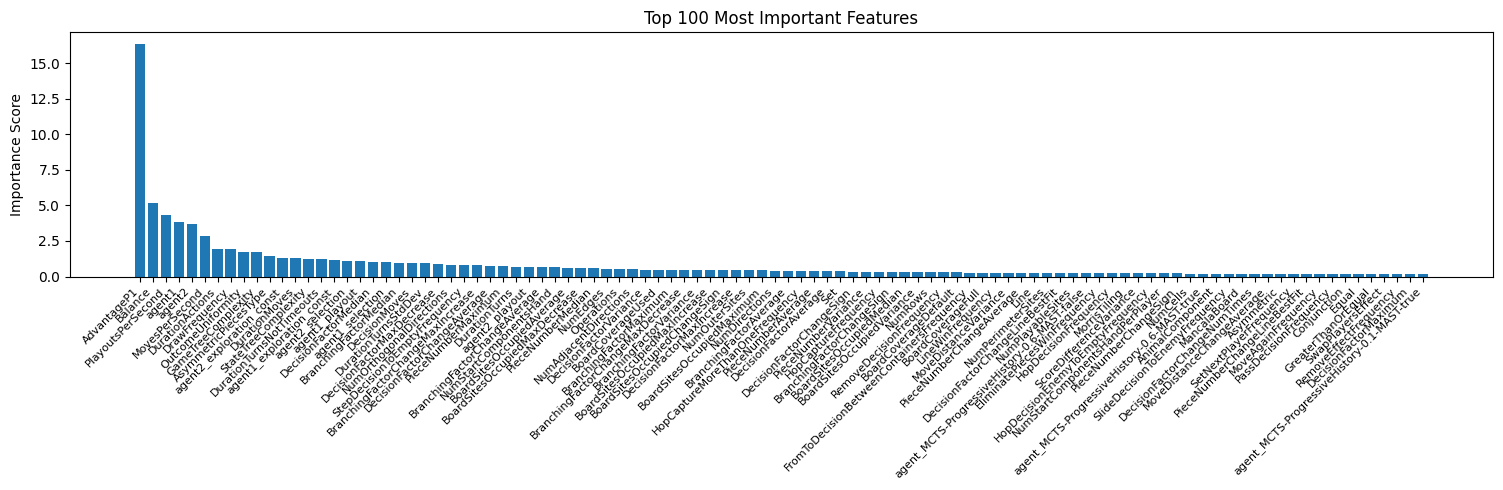

Fold 5 - RMSE: 0.40034424003146735
List of oof scores: [0.4164260903157605, 0.43853528177417755, 0.4299982975946232, 0.4387775190054084, 0.40034424003146735]
Average oof score: 0.42481628574428737


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_catboost_{fs_type}_cv1.parquet', index=False)

# save feature importance
# importance_df1.to_csv(path_results / 'feat_importance_catboost_cv1.csv', index=False)

Fold 1


0:	learn: 0.6164086	test: 0.5303969	best: 0.5303969 (0)	total: 103ms	remaining: 5m 7s


50:	learn: 0.3939786	test: 0.4544050	best: 0.4541099 (48)	total: 5.82s	remaining: 5m 36s


100:	learn: 0.3543418	test: 0.4387161	best: 0.4387161 (100)	total: 12.1s	remaining: 5m 47s


150:	learn: 0.3299596	test: 0.4316273	best: 0.4316273 (150)	total: 18.2s	remaining: 5m 43s


200:	learn: 0.3138538	test: 0.4289871	best: 0.4289626 (199)	total: 24.2s	remaining: 5m 37s


250:	learn: 0.3007619	test: 0.4259906	best: 0.4259906 (250)	total: 30.3s	remaining: 5m 31s


300:	learn: 0.2906498	test: 0.4241999	best: 0.4241835 (299)	total: 36.2s	remaining: 5m 24s


350:	learn: 0.2819745	test: 0.4225976	best: 0.4225296 (346)	total: 42.2s	remaining: 5m 18s


400:	learn: 0.2745281	test: 0.4215294	best: 0.4215294 (400)	total: 48.3s	remaining: 5m 12s


450:	learn: 0.2686606	test: 0.4205872	best: 0.4205872 (450)	total: 54.3s	remaining: 5m 6s


500:	learn: 0.2624902	test: 0.4202969	best: 0.4200692 (487)	total: 1m	remaining: 5m


550:	learn: 0.2571374	test: 0.4196340	best: 0.4195808 (547)	total: 1m 6s	remaining: 4m 54s


600:	learn: 0.2521189	test: 0.4191022	best: 0.4191022 (600)	total: 1m 12s	remaining: 4m 48s


650:	learn: 0.2478641	test: 0.4187843	best: 0.4187843 (650)	total: 1m 18s	remaining: 4m 42s


700:	learn: 0.2437641	test: 0.4182710	best: 0.4182642 (699)	total: 1m 24s	remaining: 4m 37s


750:	learn: 0.2400001	test: 0.4177970	best: 0.4177970 (750)	total: 1m 30s	remaining: 4m 31s


800:	learn: 0.2365461	test: 0.4174365	best: 0.4174152 (778)	total: 1m 36s	remaining: 4m 25s


850:	learn: 0.2331170	test: 0.4172566	best: 0.4172566 (850)	total: 1m 42s	remaining: 4m 19s


900:	learn: 0.2304228	test: 0.4170959	best: 0.4170906 (889)	total: 1m 48s	remaining: 4m 13s


950:	learn: 0.2276201	test: 0.4170109	best: 0.4169728 (937)	total: 1m 54s	remaining: 4m 7s


1000:	learn: 0.2249855	test: 0.4167310	best: 0.4167310 (1000)	total: 2m	remaining: 4m 1s


1050:	learn: 0.2224519	test: 0.4166115	best: 0.4165814 (1024)	total: 2m 6s	remaining: 3m 55s


1100:	learn: 0.2198979	test: 0.4164162	best: 0.4163935 (1097)	total: 2m 13s	remaining: 3m 49s


1150:	learn: 0.2176029	test: 0.4162105	best: 0.4162017 (1145)	total: 2m 19s	remaining: 3m 43s


1200:	learn: 0.2153352	test: 0.4161184	best: 0.4160978 (1189)	total: 2m 25s	remaining: 3m 37s


1250:	learn: 0.2132214	test: 0.4161004	best: 0.4160608 (1240)	total: 2m 31s	remaining: 3m 31s


1300:	learn: 0.2109640	test: 0.4158857	best: 0.4158526 (1295)	total: 2m 37s	remaining: 3m 25s


1350:	learn: 0.2088633	test: 0.4159186	best: 0.4158464 (1342)	total: 2m 43s	remaining: 3m 19s


1400:	learn: 0.2069287	test: 0.4160090	best: 0.4158464 (1342)	total: 2m 49s	remaining: 3m 13s


1450:	learn: 0.2050476	test: 0.4159942	best: 0.4158464 (1342)	total: 2m 55s	remaining: 3m 7s


1500:	learn: 0.2031985	test: 0.4159467	best: 0.4158464 (1342)	total: 3m 1s	remaining: 3m 1s


1550:	learn: 0.2014907	test: 0.4159652	best: 0.4158464 (1342)	total: 3m 7s	remaining: 2m 55s


1600:	learn: 0.1997232	test: 0.4158508	best: 0.4158464 (1342)	total: 3m 13s	remaining: 2m 49s


1650:	learn: 0.1980085	test: 0.4157825	best: 0.4157825 (1650)	total: 3m 19s	remaining: 2m 43s


1700:	learn: 0.1963181	test: 0.4157678	best: 0.4157472 (1698)	total: 3m 25s	remaining: 2m 37s


1750:	learn: 0.1946862	test: 0.4157118	best: 0.4156901 (1743)	total: 3m 31s	remaining: 2m 31s


1800:	learn: 0.1931473	test: 0.4157110	best: 0.4156901 (1743)	total: 3m 37s	remaining: 2m 25s


1850:	learn: 0.1916712	test: 0.4156008	best: 0.4156008 (1850)	total: 3m 43s	remaining: 2m 18s


1900:	learn: 0.1901095	test: 0.4156279	best: 0.4155843 (1875)	total: 3m 49s	remaining: 2m 12s


1950:	learn: 0.1885639	test: 0.4157219	best: 0.4155843 (1875)	total: 3m 56s	remaining: 2m 6s


2000:	learn: 0.1871901	test: 0.4156493	best: 0.4155843 (1875)	total: 4m 2s	remaining: 2m


2050:	learn: 0.1857137	test: 0.4156085	best: 0.4155843 (1875)	total: 4m 7s	remaining: 1m 54s


2100:	learn: 0.1843618	test: 0.4155283	best: 0.4155184 (2095)	total: 4m 14s	remaining: 1m 48s


2150:	learn: 0.1831796	test: 0.4155167	best: 0.4154858 (2131)	total: 4m 20s	remaining: 1m 42s


2200:	learn: 0.1818087	test: 0.4155595	best: 0.4154858 (2131)	total: 4m 26s	remaining: 1m 36s


2250:	learn: 0.1806362	test: 0.4155151	best: 0.4154858 (2131)	total: 4m 32s	remaining: 1m 30s


2300:	learn: 0.1794047	test: 0.4153937	best: 0.4153937 (2300)	total: 4m 37s	remaining: 1m 24s


2350:	learn: 0.1781952	test: 0.4153629	best: 0.4153449 (2322)	total: 4m 43s	remaining: 1m 18s


2400:	learn: 0.1767997	test: 0.4153158	best: 0.4152874 (2383)	total: 4m 49s	remaining: 1m 12s


2450:	learn: 0.1755341	test: 0.4153313	best: 0.4152849 (2425)	total: 4m 55s	remaining: 1m 6s


2500:	learn: 0.1743013	test: 0.4152347	best: 0.4152327 (2498)	total: 5m 1s	remaining: 1m


2550:	learn: 0.1730914	test: 0.4151922	best: 0.4151922 (2550)	total: 5m 7s	remaining: 54.2s


2600:	learn: 0.1719881	test: 0.4152060	best: 0.4151780 (2562)	total: 5m 13s	remaining: 48.1s


2650:	learn: 0.1707252	test: 0.4152211	best: 0.4151780 (2562)	total: 5m 19s	remaining: 42.1s


2700:	learn: 0.1695539	test: 0.4152592	best: 0.4151780 (2562)	total: 5m 25s	remaining: 36s


2750:	learn: 0.1684608	test: 0.4152385	best: 0.4151780 (2562)	total: 5m 31s	remaining: 30s


2800:	learn: 0.1673766	test: 0.4152361	best: 0.4151780 (2562)	total: 5m 37s	remaining: 24s


2850:	learn: 0.1663479	test: 0.4152672	best: 0.4151780 (2562)	total: 5m 44s	remaining: 18s


2900:	learn: 0.1652462	test: 0.4152670	best: 0.4151780 (2562)	total: 5m 49s	remaining: 11.9s


2950:	learn: 0.1642650	test: 0.4152749	best: 0.4151780 (2562)	total: 5m 56s	remaining: 5.91s


2999:	learn: 0.1631666	test: 0.4152190	best: 0.4151780 (2562)	total: 6m 2s	remaining: 0us

bestTest = 0.4151779919
bestIteration = 2562

Shrink model to first 2563 iterations.


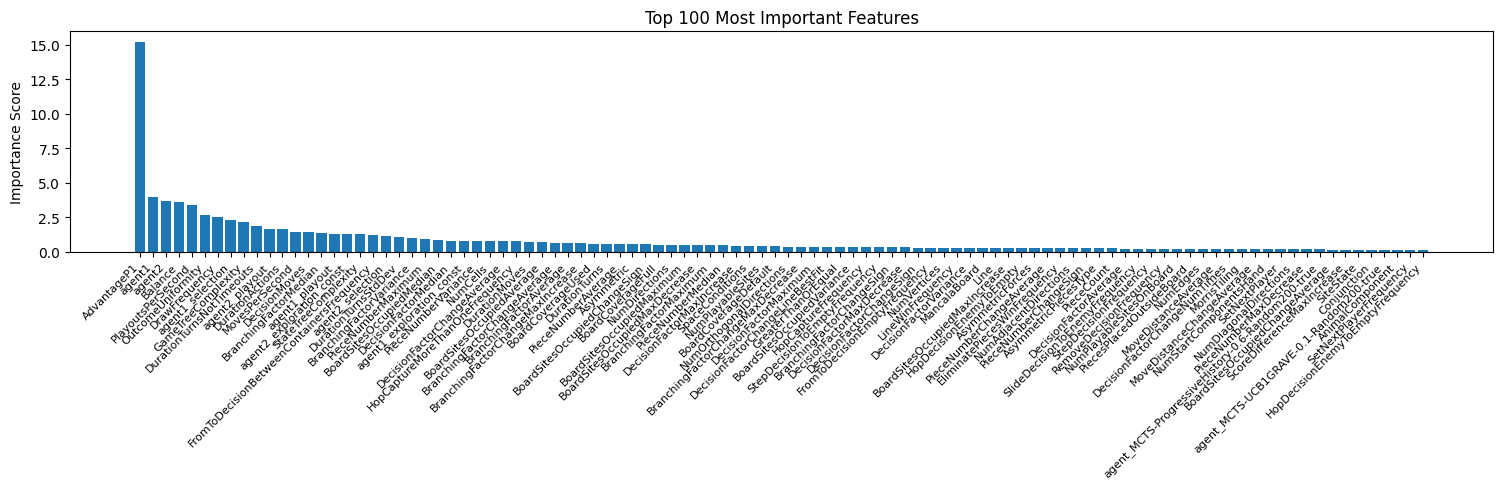

Fold 1 - RMSE: 0.4149126517708792
Fold 2


0:	learn: 0.6144692	test: 0.5388007	best: 0.5388007 (0)	total: 108ms	remaining: 5m 22s


50:	learn: 0.3888553	test: 0.4276134	best: 0.4276134 (50)	total: 5.93s	remaining: 5m 43s


100:	learn: 0.3514127	test: 0.4158959	best: 0.4154858 (99)	total: 12.1s	remaining: 5m 47s


150:	learn: 0.3281467	test: 0.4097106	best: 0.4097106 (150)	total: 18.1s	remaining: 5m 41s


200:	learn: 0.3121864	test: 0.4073775	best: 0.4073775 (200)	total: 24.1s	remaining: 5m 36s


250:	learn: 0.3002691	test: 0.4068081	best: 0.4067549 (238)	total: 30.3s	remaining: 5m 31s


300:	learn: 0.2888426	test: 0.4056465	best: 0.4056465 (300)	total: 36.1s	remaining: 5m 24s


350:	learn: 0.2804987	test: 0.4049975	best: 0.4049975 (350)	total: 42.3s	remaining: 5m 19s


400:	learn: 0.2733454	test: 0.4042280	best: 0.4042280 (400)	total: 48.3s	remaining: 5m 12s


450:	learn: 0.2671677	test: 0.4039366	best: 0.4039366 (450)	total: 54.4s	remaining: 5m 7s


500:	learn: 0.2617922	test: 0.4033493	best: 0.4033261 (496)	total: 1m	remaining: 5m 1s


550:	learn: 0.2568932	test: 0.4030766	best: 0.4030283 (511)	total: 1m 6s	remaining: 4m 55s


600:	learn: 0.2520616	test: 0.4029358	best: 0.4029051 (578)	total: 1m 12s	remaining: 4m 49s


650:	learn: 0.2480768	test: 0.4027684	best: 0.4027553 (644)	total: 1m 18s	remaining: 4m 44s


700:	learn: 0.2440973	test: 0.4026173	best: 0.4025868 (694)	total: 1m 24s	remaining: 4m 38s


750:	learn: 0.2404722	test: 0.4024102	best: 0.4024070 (749)	total: 1m 30s	remaining: 4m 32s


800:	learn: 0.2370325	test: 0.4023808	best: 0.4023222 (781)	total: 1m 37s	remaining: 4m 26s


850:	learn: 0.2339311	test: 0.4023619	best: 0.4022784 (835)	total: 1m 43s	remaining: 4m 20s


900:	learn: 0.2308008	test: 0.4022633	best: 0.4022313 (864)	total: 1m 49s	remaining: 4m 14s


950:	learn: 0.2278585	test: 0.4021363	best: 0.4021351 (949)	total: 1m 55s	remaining: 4m 8s


1000:	learn: 0.2254284	test: 0.4021546	best: 0.4020921 (976)	total: 2m 1s	remaining: 4m 2s


1050:	learn: 0.2229439	test: 0.4020965	best: 0.4020921 (976)	total: 2m 7s	remaining: 3m 56s


1100:	learn: 0.2204761	test: 0.4019665	best: 0.4019665 (1100)	total: 2m 13s	remaining: 3m 50s


1150:	learn: 0.2181393	test: 0.4018445	best: 0.4018394 (1146)	total: 2m 19s	remaining: 3m 44s


1200:	learn: 0.2159431	test: 0.4018796	best: 0.4018056 (1184)	total: 2m 25s	remaining: 3m 38s


1250:	learn: 0.2136831	test: 0.4017906	best: 0.4017888 (1248)	total: 2m 32s	remaining: 3m 32s


1300:	learn: 0.2115494	test: 0.4017194	best: 0.4017190 (1297)	total: 2m 38s	remaining: 3m 26s


1350:	learn: 0.2095272	test: 0.4017154	best: 0.4016567 (1344)	total: 2m 44s	remaining: 3m 20s


1400:	learn: 0.2076072	test: 0.4017474	best: 0.4016567 (1344)	total: 2m 50s	remaining: 3m 14s


1450:	learn: 0.2057661	test: 0.4018264	best: 0.4016567 (1344)	total: 2m 56s	remaining: 3m 8s


1500:	learn: 0.2040261	test: 0.4018066	best: 0.4016567 (1344)	total: 3m 2s	remaining: 3m 2s


1550:	learn: 0.2020712	test: 0.4016489	best: 0.4016203 (1528)	total: 3m 8s	remaining: 2m 56s


1600:	learn: 0.2003524	test: 0.4016770	best: 0.4016118 (1566)	total: 3m 15s	remaining: 2m 50s


1650:	learn: 0.1987403	test: 0.4017834	best: 0.4016118 (1566)	total: 3m 21s	remaining: 2m 44s


1700:	learn: 0.1971693	test: 0.4017617	best: 0.4016118 (1566)	total: 3m 27s	remaining: 2m 38s


1750:	learn: 0.1955678	test: 0.4017328	best: 0.4016118 (1566)	total: 3m 33s	remaining: 2m 32s


1800:	learn: 0.1940733	test: 0.4016739	best: 0.4016118 (1566)	total: 3m 40s	remaining: 2m 26s


1850:	learn: 0.1925199	test: 0.4017298	best: 0.4016118 (1566)	total: 3m 46s	remaining: 2m 20s


1900:	learn: 0.1910557	test: 0.4017163	best: 0.4016118 (1566)	total: 3m 52s	remaining: 2m 14s


1950:	learn: 0.1895819	test: 0.4017276	best: 0.4016118 (1566)	total: 3m 59s	remaining: 2m 8s


2000:	learn: 0.1880925	test: 0.4017463	best: 0.4016118 (1566)	total: 4m 5s	remaining: 2m 2s


2050:	learn: 0.1866285	test: 0.4018112	best: 0.4016118 (1566)	total: 4m 11s	remaining: 1m 56s


2100:	learn: 0.1852805	test: 0.4017644	best: 0.4016118 (1566)	total: 4m 18s	remaining: 1m 50s


2150:	learn: 0.1840408	test: 0.4017587	best: 0.4016118 (1566)	total: 4m 24s	remaining: 1m 44s


2200:	learn: 0.1827789	test: 0.4017675	best: 0.4016118 (1566)	total: 4m 30s	remaining: 1m 38s


2250:	learn: 0.1814401	test: 0.4018536	best: 0.4016118 (1566)	total: 4m 36s	remaining: 1m 32s


2300:	learn: 0.1801464	test: 0.4018149	best: 0.4016118 (1566)	total: 4m 43s	remaining: 1m 26s


2350:	learn: 0.1788204	test: 0.4018724	best: 0.4016118 (1566)	total: 4m 49s	remaining: 1m 19s


2400:	learn: 0.1775350	test: 0.4018926	best: 0.4016118 (1566)	total: 4m 55s	remaining: 1m 13s


2450:	learn: 0.1764053	test: 0.4019351	best: 0.4016118 (1566)	total: 5m 1s	remaining: 1m 7s


2500:	learn: 0.1752118	test: 0.4018800	best: 0.4016118 (1566)	total: 5m 8s	remaining: 1m 1s


2550:	learn: 0.1740262	test: 0.4018776	best: 0.4016118 (1566)	total: 5m 14s	remaining: 55.4s


2600:	learn: 0.1728372	test: 0.4018855	best: 0.4016118 (1566)	total: 5m 21s	remaining: 49.3s


2650:	learn: 0.1716524	test: 0.4019130	best: 0.4016118 (1566)	total: 5m 27s	remaining: 43.2s


2700:	learn: 0.1705159	test: 0.4019926	best: 0.4016118 (1566)	total: 5m 34s	remaining: 37s


2750:	learn: 0.1694070	test: 0.4020239	best: 0.4016118 (1566)	total: 5m 40s	remaining: 30.8s


2800:	learn: 0.1683499	test: 0.4020363	best: 0.4016118 (1566)	total: 5m 47s	remaining: 24.7s


2850:	learn: 0.1672701	test: 0.4020985	best: 0.4016118 (1566)	total: 5m 53s	remaining: 18.5s


2900:	learn: 0.1661934	test: 0.4021105	best: 0.4016118 (1566)	total: 5m 59s	remaining: 12.3s


2950:	learn: 0.1650686	test: 0.4021881	best: 0.4016118 (1566)	total: 6m 6s	remaining: 6.08s


2999:	learn: 0.1641548	test: 0.4022021	best: 0.4016118 (1566)	total: 6m 12s	remaining: 0us

bestTest = 0.4016118066
bestIteration = 1566

Shrink model to first 1567 iterations.


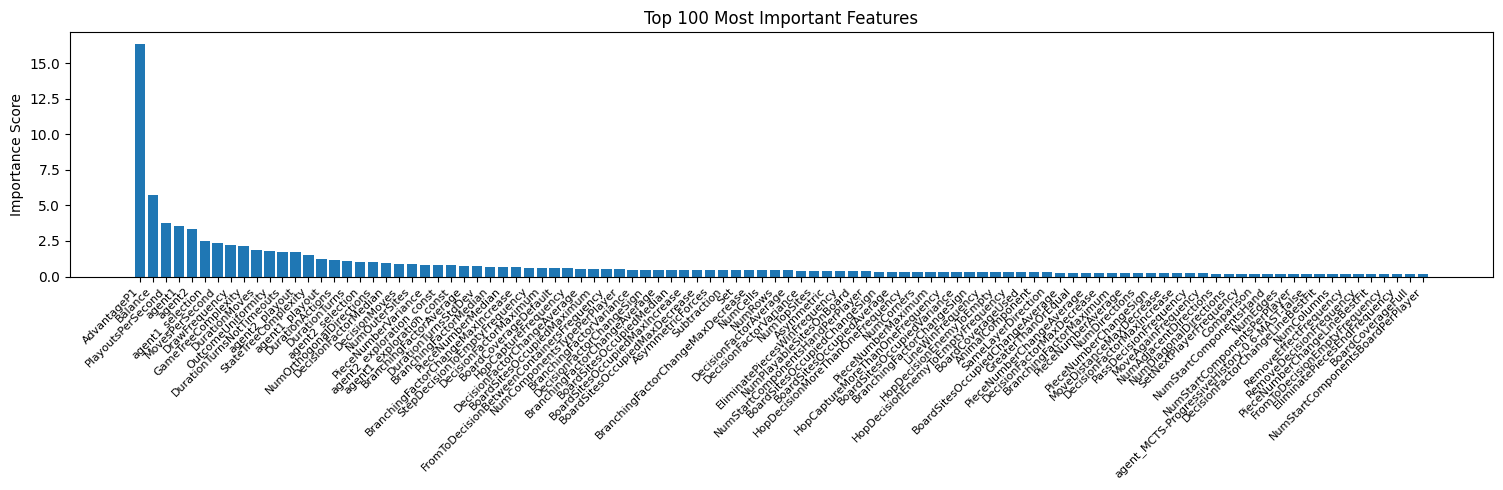

Fold 2 - RMSE: 0.40116114895348964
Fold 3


0:	learn: 0.6017718	test: 0.6058830	best: 0.6058830 (0)	total: 107ms	remaining: 5m 20s


50:	learn: 0.3836597	test: 0.4794290	best: 0.4794290 (50)	total: 6.27s	remaining: 6m 2s


100:	learn: 0.3459869	test: 0.4586251	best: 0.4586251 (100)	total: 12.7s	remaining: 6m 4s


150:	learn: 0.3208713	test: 0.4474117	best: 0.4473161 (149)	total: 18.9s	remaining: 5m 56s


200:	learn: 0.3045567	test: 0.4426202	best: 0.4426111 (199)	total: 25s	remaining: 5m 48s


250:	learn: 0.2931068	test: 0.4393339	best: 0.4393339 (250)	total: 31.4s	remaining: 5m 43s


300:	learn: 0.2840046	test: 0.4367712	best: 0.4367712 (300)	total: 37.5s	remaining: 5m 36s


350:	learn: 0.2765748	test: 0.4354026	best: 0.4353981 (346)	total: 43.7s	remaining: 5m 29s


400:	learn: 0.2701266	test: 0.4341000	best: 0.4341000 (400)	total: 49.9s	remaining: 5m 23s


450:	learn: 0.2641047	test: 0.4333329	best: 0.4333329 (450)	total: 56.2s	remaining: 5m 17s


500:	learn: 0.2593414	test: 0.4323235	best: 0.4323235 (500)	total: 1m 2s	remaining: 5m 13s


550:	learn: 0.2542011	test: 0.4315127	best: 0.4315127 (550)	total: 1m 9s	remaining: 5m 7s


600:	learn: 0.2498392	test: 0.4310858	best: 0.4310824 (590)	total: 1m 15s	remaining: 5m


650:	learn: 0.2458976	test: 0.4305034	best: 0.4304999 (649)	total: 1m 21s	remaining: 4m 53s


700:	learn: 0.2422986	test: 0.4298614	best: 0.4298541 (698)	total: 1m 27s	remaining: 4m 47s


750:	learn: 0.2389745	test: 0.4295279	best: 0.4295112 (747)	total: 1m 34s	remaining: 4m 41s


800:	learn: 0.2356829	test: 0.4289756	best: 0.4289756 (800)	total: 1m 40s	remaining: 4m 35s


850:	learn: 0.2325132	test: 0.4286647	best: 0.4286647 (850)	total: 1m 46s	remaining: 4m 29s


900:	learn: 0.2299984	test: 0.4283268	best: 0.4283075 (897)	total: 1m 53s	remaining: 4m 23s


950:	learn: 0.2272261	test: 0.4281515	best: 0.4281515 (950)	total: 1m 59s	remaining: 4m 17s


1000:	learn: 0.2245926	test: 0.4278458	best: 0.4278387 (999)	total: 2m 5s	remaining: 4m 10s


1050:	learn: 0.2219854	test: 0.4274846	best: 0.4274846 (1050)	total: 2m 11s	remaining: 4m 4s


1100:	learn: 0.2196534	test: 0.4273920	best: 0.4273819 (1096)	total: 2m 17s	remaining: 3m 57s


1150:	learn: 0.2175302	test: 0.4273143	best: 0.4271765 (1127)	total: 2m 23s	remaining: 3m 50s


1200:	learn: 0.2153940	test: 0.4271640	best: 0.4271582 (1197)	total: 2m 29s	remaining: 3m 44s


1250:	learn: 0.2133219	test: 0.4270655	best: 0.4270655 (1250)	total: 2m 35s	remaining: 3m 38s


1300:	learn: 0.2110907	test: 0.4269405	best: 0.4269326 (1299)	total: 2m 42s	remaining: 3m 31s


1350:	learn: 0.2092363	test: 0.4268728	best: 0.4268728 (1350)	total: 2m 48s	remaining: 3m 25s


1400:	learn: 0.2074921	test: 0.4267622	best: 0.4267269 (1381)	total: 2m 54s	remaining: 3m 19s


1450:	learn: 0.2055485	test: 0.4266235	best: 0.4266229 (1444)	total: 3m	remaining: 3m 12s


1500:	learn: 0.2036811	test: 0.4266664	best: 0.4266223 (1451)	total: 3m 6s	remaining: 3m 6s


1550:	learn: 0.2019093	test: 0.4264565	best: 0.4264357 (1547)	total: 3m 12s	remaining: 2m 59s


1600:	learn: 0.2001765	test: 0.4263431	best: 0.4263431 (1600)	total: 3m 18s	remaining: 2m 53s


1650:	learn: 0.1985846	test: 0.4262808	best: 0.4262797 (1641)	total: 3m 24s	remaining: 2m 47s


1700:	learn: 0.1969885	test: 0.4261234	best: 0.4260956 (1695)	total: 3m 30s	remaining: 2m 41s


1750:	learn: 0.1955537	test: 0.4261058	best: 0.4260956 (1695)	total: 3m 37s	remaining: 2m 34s


1800:	learn: 0.1939421	test: 0.4260314	best: 0.4260116 (1792)	total: 3m 43s	remaining: 2m 28s


1850:	learn: 0.1925097	test: 0.4259661	best: 0.4259621 (1849)	total: 3m 49s	remaining: 2m 22s


1900:	learn: 0.1910310	test: 0.4259121	best: 0.4259121 (1900)	total: 3m 55s	remaining: 2m 16s


1950:	learn: 0.1896447	test: 0.4259389	best: 0.4259037 (1901)	total: 4m 1s	remaining: 2m 9s


2000:	learn: 0.1883301	test: 0.4258426	best: 0.4258327 (1995)	total: 4m 7s	remaining: 2m 3s


2050:	learn: 0.1868943	test: 0.4256444	best: 0.4256444 (2050)	total: 4m 13s	remaining: 1m 57s


2100:	learn: 0.1855051	test: 0.4255494	best: 0.4255470 (2099)	total: 4m 19s	remaining: 1m 51s


2150:	learn: 0.1839808	test: 0.4255192	best: 0.4255017 (2146)	total: 4m 26s	remaining: 1m 45s


2200:	learn: 0.1827834	test: 0.4254084	best: 0.4254000 (2194)	total: 4m 32s	remaining: 1m 38s


2250:	learn: 0.1815433	test: 0.4252595	best: 0.4252490 (2237)	total: 4m 38s	remaining: 1m 32s


2300:	learn: 0.1802980	test: 0.4253157	best: 0.4252490 (2237)	total: 4m 44s	remaining: 1m 26s


2350:	learn: 0.1792316	test: 0.4252814	best: 0.4252490 (2237)	total: 4m 50s	remaining: 1m 20s


2400:	learn: 0.1780526	test: 0.4251511	best: 0.4251420 (2397)	total: 4m 56s	remaining: 1m 14s


2450:	learn: 0.1768032	test: 0.4250856	best: 0.4250856 (2450)	total: 5m 2s	remaining: 1m 7s


2500:	learn: 0.1757254	test: 0.4250857	best: 0.4250683 (2492)	total: 5m 8s	remaining: 1m 1s


2550:	learn: 0.1745362	test: 0.4250912	best: 0.4250435 (2516)	total: 5m 15s	remaining: 55.4s


2600:	learn: 0.1734795	test: 0.4250908	best: 0.4250435 (2516)	total: 5m 21s	remaining: 49.3s


2650:	learn: 0.1723469	test: 0.4250864	best: 0.4250435 (2516)	total: 5m 27s	remaining: 43.1s


2700:	learn: 0.1712994	test: 0.4250665	best: 0.4250435 (2516)	total: 5m 33s	remaining: 36.9s


2750:	learn: 0.1701520	test: 0.4251003	best: 0.4250435 (2516)	total: 5m 39s	remaining: 30.7s


2800:	learn: 0.1690940	test: 0.4251033	best: 0.4250435 (2516)	total: 5m 45s	remaining: 24.6s


2850:	learn: 0.1681046	test: 0.4251064	best: 0.4250435 (2516)	total: 5m 51s	remaining: 18.4s


2900:	learn: 0.1671019	test: 0.4251344	best: 0.4250435 (2516)	total: 5m 57s	remaining: 12.2s


2950:	learn: 0.1660880	test: 0.4250873	best: 0.4250435 (2516)	total: 6m 3s	remaining: 6.04s


2999:	learn: 0.1651310	test: 0.4251702	best: 0.4250435 (2516)	total: 6m 9s	remaining: 0us

bestTest = 0.4250435341
bestIteration = 2516

Shrink model to first 2517 iterations.


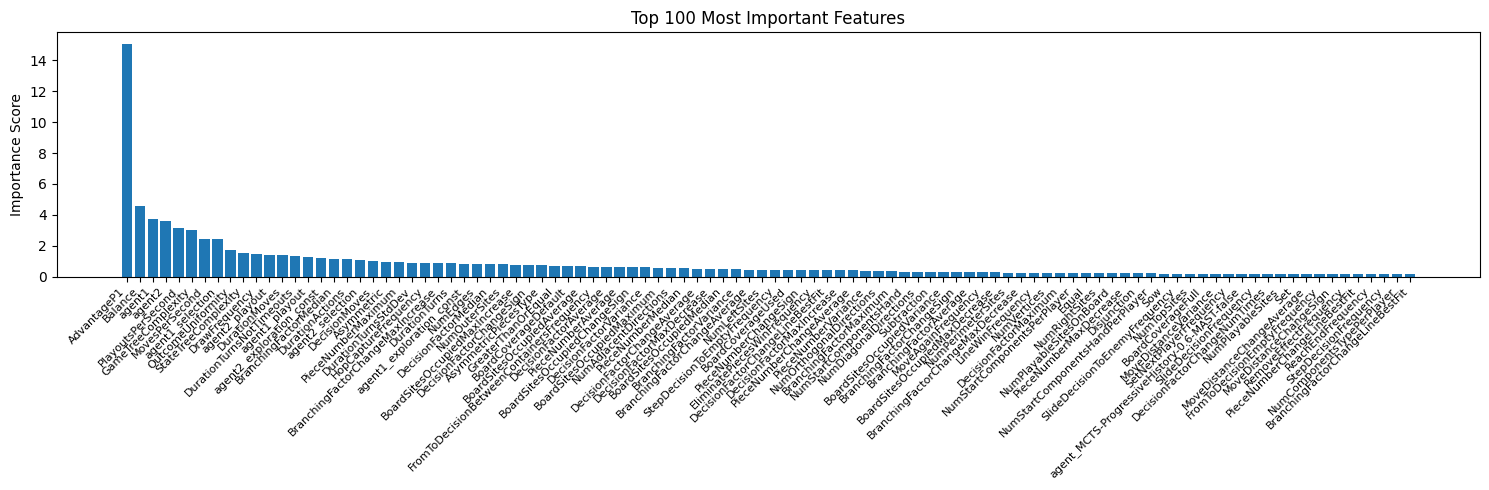

Fold 3 - RMSE: 0.4242797432143801
Fold 4


0:	learn: 0.6028858	test: 0.5979542	best: 0.5979542 (0)	total: 102ms	remaining: 5m 5s


50:	learn: 0.3888528	test: 0.4852654	best: 0.4852654 (50)	total: 5.71s	remaining: 5m 30s


100:	learn: 0.3506235	test: 0.4677734	best: 0.4677734 (100)	total: 11.9s	remaining: 5m 41s


150:	learn: 0.3289191	test: 0.4593991	best: 0.4593991 (150)	total: 18s	remaining: 5m 40s


200:	learn: 0.3135700	test: 0.4550252	best: 0.4549918 (199)	total: 24.2s	remaining: 5m 36s


250:	learn: 0.3008687	test: 0.4519953	best: 0.4519953 (250)	total: 30.3s	remaining: 5m 31s


300:	learn: 0.2913821	test: 0.4499200	best: 0.4499200 (300)	total: 36.4s	remaining: 5m 26s


350:	learn: 0.2831588	test: 0.4487790	best: 0.4487344 (341)	total: 42.5s	remaining: 5m 20s


400:	learn: 0.2756339	test: 0.4474058	best: 0.4474058 (400)	total: 48.6s	remaining: 5m 14s


450:	learn: 0.2690112	test: 0.4470862	best: 0.4470289 (446)	total: 54.6s	remaining: 5m 8s


500:	learn: 0.2634326	test: 0.4466059	best: 0.4466059 (500)	total: 1m	remaining: 5m 2s


550:	learn: 0.2585626	test: 0.4459825	best: 0.4459825 (550)	total: 1m 6s	remaining: 4m 56s


600:	learn: 0.2539480	test: 0.4456561	best: 0.4456271 (599)	total: 1m 12s	remaining: 4m 50s


650:	learn: 0.2501725	test: 0.4453968	best: 0.4453680 (641)	total: 1m 19s	remaining: 4m 45s


700:	learn: 0.2467511	test: 0.4449239	best: 0.4449239 (700)	total: 1m 25s	remaining: 4m 39s


750:	learn: 0.2431236	test: 0.4446134	best: 0.4446134 (750)	total: 1m 31s	remaining: 4m 33s


800:	learn: 0.2400897	test: 0.4443731	best: 0.4443018 (783)	total: 1m 37s	remaining: 4m 27s


850:	learn: 0.2372015	test: 0.4441802	best: 0.4441311 (847)	total: 1m 43s	remaining: 4m 22s


900:	learn: 0.2345802	test: 0.4438089	best: 0.4437719 (898)	total: 1m 50s	remaining: 4m 16s


950:	learn: 0.2318798	test: 0.4435459	best: 0.4435459 (950)	total: 1m 56s	remaining: 4m 10s


1000:	learn: 0.2293502	test: 0.4432538	best: 0.4432538 (1000)	total: 2m 2s	remaining: 4m 4s


1050:	learn: 0.2267525	test: 0.4427946	best: 0.4427775 (1049)	total: 2m 8s	remaining: 3m 58s


1100:	learn: 0.2244717	test: 0.4425770	best: 0.4425770 (1100)	total: 2m 14s	remaining: 3m 52s


1150:	learn: 0.2219159	test: 0.4424067	best: 0.4423801 (1145)	total: 2m 21s	remaining: 3m 46s


1200:	learn: 0.2197057	test: 0.4421986	best: 0.4421890 (1196)	total: 2m 27s	remaining: 3m 40s


1250:	learn: 0.2178473	test: 0.4421122	best: 0.4421122 (1250)	total: 2m 33s	remaining: 3m 34s


1300:	learn: 0.2158504	test: 0.4420122	best: 0.4420122 (1300)	total: 2m 39s	remaining: 3m 28s


1350:	learn: 0.2137946	test: 0.4417818	best: 0.4417818 (1350)	total: 2m 45s	remaining: 3m 22s


1400:	learn: 0.2119662	test: 0.4417922	best: 0.4417697 (1380)	total: 2m 52s	remaining: 3m 16s


1450:	learn: 0.2100850	test: 0.4417260	best: 0.4417260 (1450)	total: 2m 58s	remaining: 3m 10s


1500:	learn: 0.2081200	test: 0.4417056	best: 0.4416973 (1462)	total: 3m 4s	remaining: 3m 4s


1550:	learn: 0.2063676	test: 0.4416456	best: 0.4416023 (1534)	total: 3m 11s	remaining: 2m 58s


1600:	learn: 0.2048084	test: 0.4416447	best: 0.4416023 (1534)	total: 3m 17s	remaining: 2m 52s


1650:	learn: 0.2031642	test: 0.4416145	best: 0.4416023 (1534)	total: 3m 23s	remaining: 2m 46s


1700:	learn: 0.2014650	test: 0.4414713	best: 0.4414378 (1691)	total: 3m 29s	remaining: 2m 40s


1750:	learn: 0.1999171	test: 0.4413716	best: 0.4413716 (1750)	total: 3m 36s	remaining: 2m 34s


1800:	learn: 0.1982741	test: 0.4413956	best: 0.4413236 (1786)	total: 3m 42s	remaining: 2m 28s


1850:	learn: 0.1966780	test: 0.4415048	best: 0.4413236 (1786)	total: 3m 48s	remaining: 2m 21s


1900:	learn: 0.1951938	test: 0.4414906	best: 0.4413236 (1786)	total: 3m 54s	remaining: 2m 15s


1950:	learn: 0.1936897	test: 0.4414493	best: 0.4413236 (1786)	total: 4m	remaining: 2m 9s


2000:	learn: 0.1922343	test: 0.4414194	best: 0.4413236 (1786)	total: 4m 7s	remaining: 2m 3s


2050:	learn: 0.1907863	test: 0.4413399	best: 0.4413100 (2040)	total: 4m 13s	remaining: 1m 57s


2100:	learn: 0.1895276	test: 0.4411394	best: 0.4411368 (2096)	total: 4m 19s	remaining: 1m 51s


2150:	learn: 0.1881564	test: 0.4412179	best: 0.4411368 (2096)	total: 4m 25s	remaining: 1m 44s


2200:	learn: 0.1868484	test: 0.4410937	best: 0.4410880 (2197)	total: 4m 32s	remaining: 1m 38s


2250:	learn: 0.1855956	test: 0.4410835	best: 0.4410719 (2209)	total: 4m 38s	remaining: 1m 32s


2300:	learn: 0.1843793	test: 0.4409628	best: 0.4409486 (2298)	total: 4m 44s	remaining: 1m 26s


2350:	learn: 0.1831626	test: 0.4409362	best: 0.4409211 (2347)	total: 4m 50s	remaining: 1m 20s


2400:	learn: 0.1819399	test: 0.4408324	best: 0.4408324 (2400)	total: 4m 57s	remaining: 1m 14s


2450:	learn: 0.1806693	test: 0.4407875	best: 0.4407682 (2431)	total: 5m 3s	remaining: 1m 7s


2500:	learn: 0.1794954	test: 0.4407431	best: 0.4407173 (2495)	total: 5m 9s	remaining: 1m 1s


2550:	learn: 0.1784226	test: 0.4407843	best: 0.4407173 (2495)	total: 5m 15s	remaining: 55.6s


2600:	learn: 0.1772062	test: 0.4407732	best: 0.4407173 (2495)	total: 5m 22s	remaining: 49.4s


2650:	learn: 0.1760954	test: 0.4407482	best: 0.4407173 (2495)	total: 5m 28s	remaining: 43.2s


2700:	learn: 0.1749380	test: 0.4407344	best: 0.4407173 (2495)	total: 5m 34s	remaining: 37s


2750:	learn: 0.1738457	test: 0.4407796	best: 0.4407173 (2495)	total: 5m 40s	remaining: 30.9s


2800:	learn: 0.1726942	test: 0.4407230	best: 0.4407173 (2495)	total: 5m 47s	remaining: 24.7s


2850:	learn: 0.1716260	test: 0.4407269	best: 0.4407049 (2838)	total: 5m 53s	remaining: 18.5s


2900:	learn: 0.1704965	test: 0.4407051	best: 0.4407049 (2838)	total: 5m 59s	remaining: 12.3s


2950:	learn: 0.1693647	test: 0.4406966	best: 0.4406665 (2913)	total: 6m 5s	remaining: 6.07s


2999:	learn: 0.1683426	test: 0.4406751	best: 0.4406665 (2913)	total: 6m 11s	remaining: 0us

bestTest = 0.4406665176
bestIteration = 2913

Shrink model to first 2914 iterations.


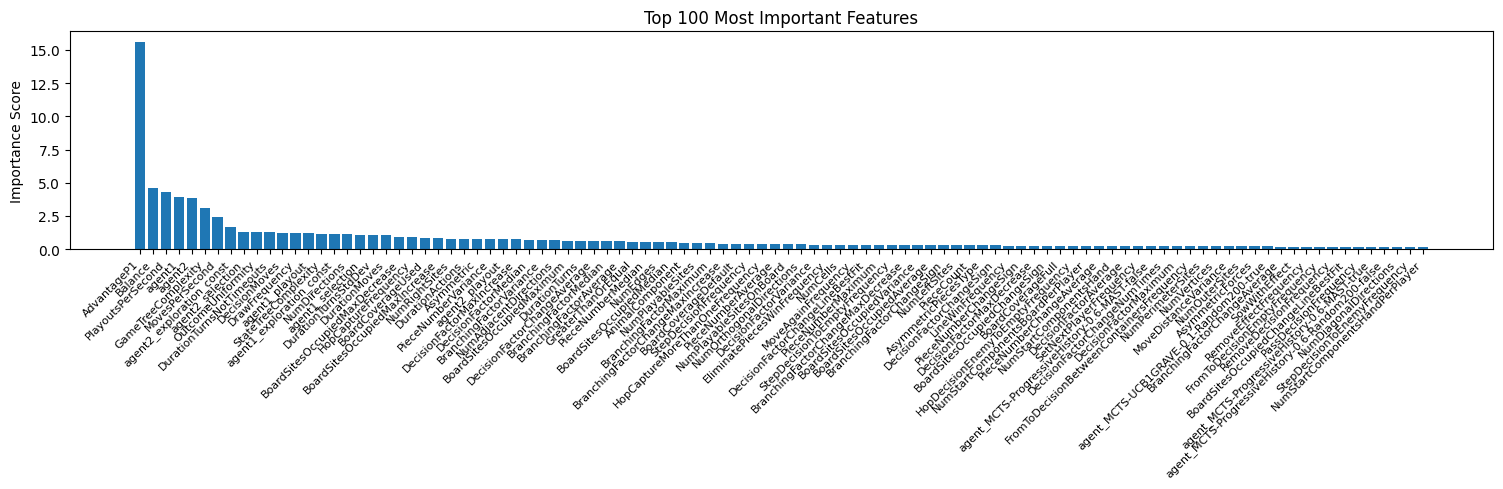

Fold 4 - RMSE: 0.44023371257879385
Fold 5


0:	learn: 0.6058716	test: 0.5863324	best: 0.5863324 (0)	total: 94.8ms	remaining: 4m 44s


50:	learn: 0.3817867	test: 0.4801888	best: 0.4801888 (50)	total: 5.76s	remaining: 5m 32s


100:	learn: 0.3463722	test: 0.4616634	best: 0.4616634 (100)	total: 11.8s	remaining: 5m 39s


150:	learn: 0.3247453	test: 0.4530204	best: 0.4530204 (150)	total: 17.9s	remaining: 5m 37s


200:	learn: 0.3099822	test: 0.4471818	best: 0.4471818 (200)	total: 23.9s	remaining: 5m 33s


250:	learn: 0.2979677	test: 0.4440511	best: 0.4440511 (250)	total: 30s	remaining: 5m 29s


300:	learn: 0.2886429	test: 0.4416919	best: 0.4416919 (300)	total: 36s	remaining: 5m 22s


350:	learn: 0.2801947	test: 0.4392865	best: 0.4392865 (350)	total: 42.1s	remaining: 5m 17s


400:	learn: 0.2736604	test: 0.4384652	best: 0.4384652 (400)	total: 48.3s	remaining: 5m 12s


450:	learn: 0.2673625	test: 0.4374580	best: 0.4374580 (450)	total: 54.3s	remaining: 5m 7s


500:	learn: 0.2622016	test: 0.4365754	best: 0.4365754 (500)	total: 1m	remaining: 5m 1s


550:	learn: 0.2571898	test: 0.4358256	best: 0.4357842 (546)	total: 1m 6s	remaining: 4m 55s


600:	learn: 0.2524921	test: 0.4352934	best: 0.4352688 (595)	total: 1m 12s	remaining: 4m 49s


650:	learn: 0.2478978	test: 0.4346691	best: 0.4346691 (650)	total: 1m 18s	remaining: 4m 43s


700:	learn: 0.2438361	test: 0.4342106	best: 0.4342106 (700)	total: 1m 24s	remaining: 4m 37s


750:	learn: 0.2401203	test: 0.4338059	best: 0.4337339 (747)	total: 1m 30s	remaining: 4m 31s


800:	learn: 0.2370825	test: 0.4334454	best: 0.4334045 (798)	total: 1m 36s	remaining: 4m 25s


850:	learn: 0.2339135	test: 0.4331612	best: 0.4331462 (848)	total: 1m 42s	remaining: 4m 20s


900:	learn: 0.2310531	test: 0.4327048	best: 0.4327048 (900)	total: 1m 49s	remaining: 4m 15s


950:	learn: 0.2281892	test: 0.4325144	best: 0.4324565 (936)	total: 1m 55s	remaining: 4m 9s


1000:	learn: 0.2256318	test: 0.4325611	best: 0.4324496 (970)	total: 2m 2s	remaining: 4m 4s


1050:	learn: 0.2233803	test: 0.4325804	best: 0.4324496 (970)	total: 2m 8s	remaining: 3m 58s


1100:	learn: 0.2207443	test: 0.4323572	best: 0.4323272 (1083)	total: 2m 14s	remaining: 3m 51s


1150:	learn: 0.2182843	test: 0.4323848	best: 0.4322941 (1121)	total: 2m 20s	remaining: 3m 45s


1200:	learn: 0.2160926	test: 0.4322517	best: 0.4322384 (1192)	total: 2m 26s	remaining: 3m 39s


1250:	learn: 0.2141331	test: 0.4321098	best: 0.4320595 (1243)	total: 2m 32s	remaining: 3m 33s


1300:	learn: 0.2122926	test: 0.4320853	best: 0.4320285 (1270)	total: 2m 39s	remaining: 3m 27s


1350:	learn: 0.2103542	test: 0.4319738	best: 0.4319494 (1342)	total: 2m 45s	remaining: 3m 21s


1400:	learn: 0.2085641	test: 0.4319168	best: 0.4318622 (1384)	total: 2m 51s	remaining: 3m 16s


1450:	learn: 0.2068216	test: 0.4318665	best: 0.4318622 (1384)	total: 2m 58s	remaining: 3m 10s


1500:	learn: 0.2052443	test: 0.4317714	best: 0.4317714 (1500)	total: 3m 4s	remaining: 3m 4s


1550:	learn: 0.2036063	test: 0.4316417	best: 0.4316417 (1550)	total: 3m 10s	remaining: 2m 58s


1600:	learn: 0.2019381	test: 0.4314211	best: 0.4314195 (1598)	total: 3m 17s	remaining: 2m 52s


1650:	learn: 0.2003721	test: 0.4312232	best: 0.4312232 (1650)	total: 3m 23s	remaining: 2m 46s


1700:	learn: 0.1988492	test: 0.4311623	best: 0.4311623 (1700)	total: 3m 29s	remaining: 2m 39s


1750:	learn: 0.1973962	test: 0.4311314	best: 0.4310753 (1733)	total: 3m 35s	remaining: 2m 33s


1800:	learn: 0.1959898	test: 0.4311018	best: 0.4310557 (1793)	total: 3m 41s	remaining: 2m 27s


1850:	learn: 0.1944877	test: 0.4311142	best: 0.4310557 (1793)	total: 3m 47s	remaining: 2m 21s


1900:	learn: 0.1930309	test: 0.4311309	best: 0.4310557 (1793)	total: 3m 54s	remaining: 2m 15s


1950:	learn: 0.1915068	test: 0.4311336	best: 0.4310557 (1793)	total: 4m	remaining: 2m 9s


2000:	learn: 0.1902517	test: 0.4310612	best: 0.4310557 (1793)	total: 4m 6s	remaining: 2m 2s


2050:	learn: 0.1889679	test: 0.4311800	best: 0.4310486 (2002)	total: 4m 12s	remaining: 1m 56s


2100:	learn: 0.1876463	test: 0.4311452	best: 0.4310486 (2002)	total: 4m 18s	remaining: 1m 50s


2150:	learn: 0.1863040	test: 0.4311212	best: 0.4310486 (2002)	total: 4m 24s	remaining: 1m 44s


2200:	learn: 0.1850130	test: 0.4310987	best: 0.4310486 (2002)	total: 4m 30s	remaining: 1m 38s


2250:	learn: 0.1836602	test: 0.4310363	best: 0.4310348 (2249)	total: 4m 36s	remaining: 1m 32s


2300:	learn: 0.1823846	test: 0.4310102	best: 0.4309886 (2288)	total: 4m 42s	remaining: 1m 25s


2350:	learn: 0.1810823	test: 0.4309300	best: 0.4309292 (2349)	total: 4m 48s	remaining: 1m 19s


2400:	learn: 0.1798774	test: 0.4309077	best: 0.4308835 (2375)	total: 4m 55s	remaining: 1m 13s


2450:	learn: 0.1787685	test: 0.4308390	best: 0.4308295 (2448)	total: 5m 1s	remaining: 1m 7s


2500:	learn: 0.1776493	test: 0.4307995	best: 0.4307995 (2500)	total: 5m 7s	remaining: 1m 1s


2550:	learn: 0.1765554	test: 0.4307708	best: 0.4307658 (2548)	total: 5m 14s	remaining: 55.3s


2600:	learn: 0.1754512	test: 0.4306983	best: 0.4306983 (2600)	total: 5m 20s	remaining: 49.2s


2650:	learn: 0.1743443	test: 0.4306201	best: 0.4306201 (2650)	total: 5m 26s	remaining: 43s


2700:	learn: 0.1731998	test: 0.4306198	best: 0.4306120 (2660)	total: 5m 32s	remaining: 36.9s


2750:	learn: 0.1721005	test: 0.4305795	best: 0.4305716 (2745)	total: 5m 39s	remaining: 30.7s


2800:	learn: 0.1709459	test: 0.4305578	best: 0.4305495 (2768)	total: 5m 45s	remaining: 24.5s


2850:	learn: 0.1698863	test: 0.4305389	best: 0.4305253 (2845)	total: 5m 51s	remaining: 18.4s


2900:	learn: 0.1689170	test: 0.4305305	best: 0.4305005 (2869)	total: 5m 57s	remaining: 12.2s


2950:	learn: 0.1679634	test: 0.4304964	best: 0.4304925 (2947)	total: 6m 4s	remaining: 6.05s


2999:	learn: 0.1669525	test: 0.4305825	best: 0.4304848 (2962)	total: 6m 10s	remaining: 0us

bestTest = 0.4304847908
bestIteration = 2962

Shrink model to first 2963 iterations.


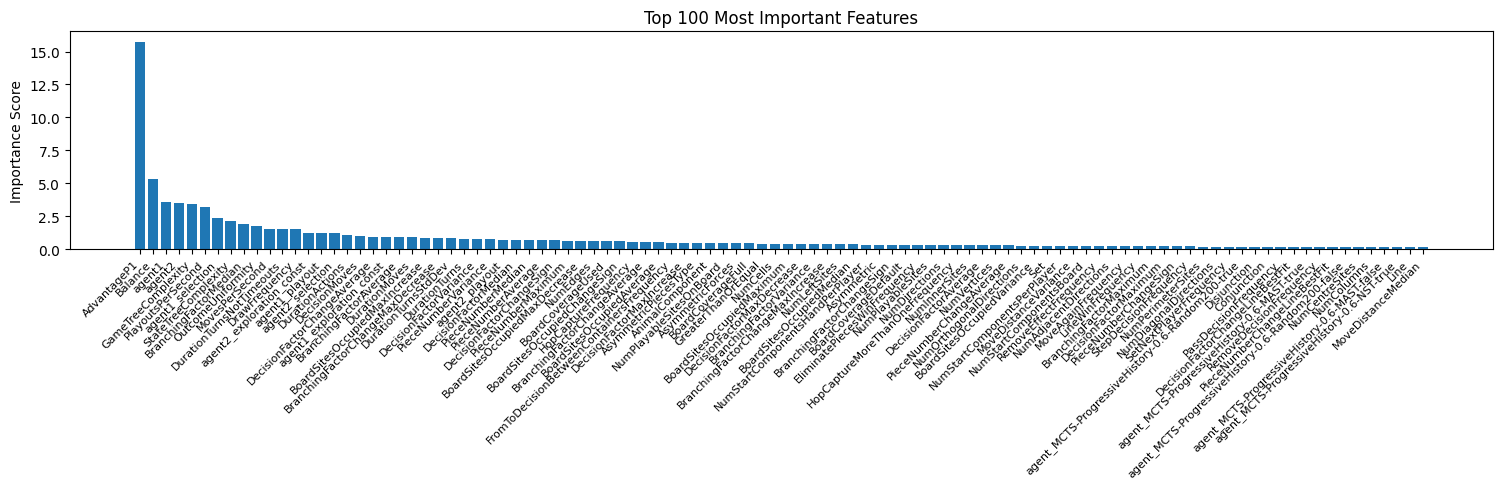

Fold 5 - RMSE: 0.42993846586464196
List of oof scores: [0.4149126517708792, 0.40116114895348964, 0.4242797432143801, 0.44023371257879385, 0.42993846586464196]
Average oof score: 0.42210514447643693


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_catboost_{fs_type}_cv2.parquet', index=False)

Fold 1


0:	learn: 0.6083261	test: 0.5713670	best: 0.5713670 (0)	total: 93.5ms	remaining: 4m 40s


50:	learn: 0.3892079	test: 0.4683993	best: 0.4683993 (50)	total: 5.99s	remaining: 5m 46s


100:	learn: 0.3506714	test: 0.4544104	best: 0.4544104 (100)	total: 12.3s	remaining: 5m 52s


150:	learn: 0.3272945	test: 0.4462689	best: 0.4462689 (150)	total: 18.4s	remaining: 5m 47s


200:	learn: 0.3114183	test: 0.4424809	best: 0.4423366 (197)	total: 24.6s	remaining: 5m 42s


250:	learn: 0.2989875	test: 0.4406380	best: 0.4404196 (242)	total: 30.6s	remaining: 5m 35s


300:	learn: 0.2896174	test: 0.4390345	best: 0.4390109 (289)	total: 36.8s	remaining: 5m 30s


350:	learn: 0.2817130	test: 0.4375407	best: 0.4374827 (348)	total: 43s	remaining: 5m 24s


400:	learn: 0.2748412	test: 0.4366426	best: 0.4365110 (389)	total: 49.2s	remaining: 5m 18s


450:	learn: 0.2681783	test: 0.4361296	best: 0.4361296 (450)	total: 55.2s	remaining: 5m 12s


500:	learn: 0.2624031	test: 0.4357699	best: 0.4355915 (494)	total: 1m 1s	remaining: 5m 6s


550:	learn: 0.2574130	test: 0.4354350	best: 0.4353316 (539)	total: 1m 7s	remaining: 5m


600:	learn: 0.2530081	test: 0.4350574	best: 0.4350095 (597)	total: 1m 13s	remaining: 4m 54s


650:	learn: 0.2489619	test: 0.4346906	best: 0.4346544 (646)	total: 1m 19s	remaining: 4m 47s


700:	learn: 0.2454771	test: 0.4344360	best: 0.4344327 (699)	total: 1m 25s	remaining: 4m 41s


750:	learn: 0.2420649	test: 0.4340986	best: 0.4340680 (743)	total: 1m 32s	remaining: 4m 35s


800:	learn: 0.2387867	test: 0.4339679	best: 0.4339470 (788)	total: 1m 38s	remaining: 4m 29s


850:	learn: 0.2357449	test: 0.4336159	best: 0.4336159 (850)	total: 1m 44s	remaining: 4m 23s


900:	learn: 0.2330353	test: 0.4336397	best: 0.4335561 (883)	total: 1m 50s	remaining: 4m 17s


950:	learn: 0.2301783	test: 0.4335650	best: 0.4335443 (942)	total: 1m 56s	remaining: 4m 11s


1000:	learn: 0.2277518	test: 0.4334939	best: 0.4334696 (992)	total: 2m 2s	remaining: 4m 5s


1050:	learn: 0.2252067	test: 0.4333332	best: 0.4333129 (1049)	total: 2m 8s	remaining: 3m 59s


1100:	learn: 0.2230087	test: 0.4333515	best: 0.4332937 (1094)	total: 2m 15s	remaining: 3m 53s


1150:	learn: 0.2206051	test: 0.4332815	best: 0.4332582 (1108)	total: 2m 21s	remaining: 3m 46s


1200:	learn: 0.2184568	test: 0.4332344	best: 0.4332290 (1155)	total: 2m 27s	remaining: 3m 41s


1250:	learn: 0.2163448	test: 0.4332000	best: 0.4331922 (1249)	total: 2m 34s	remaining: 3m 35s


1300:	learn: 0.2142612	test: 0.4331274	best: 0.4331274 (1300)	total: 2m 40s	remaining: 3m 29s


1350:	learn: 0.2123926	test: 0.4328145	best: 0.4328108 (1349)	total: 2m 46s	remaining: 3m 23s


1400:	learn: 0.2105586	test: 0.4327368	best: 0.4327368 (1400)	total: 2m 52s	remaining: 3m 17s


1450:	learn: 0.2089058	test: 0.4328009	best: 0.4327367 (1404)	total: 2m 58s	remaining: 3m 11s


1500:	learn: 0.2071891	test: 0.4327297	best: 0.4327281 (1494)	total: 3m 5s	remaining: 3m 4s


1550:	learn: 0.2055090	test: 0.4328028	best: 0.4327277 (1502)	total: 3m 11s	remaining: 2m 58s


1600:	learn: 0.2038293	test: 0.4328252	best: 0.4327277 (1502)	total: 3m 17s	remaining: 2m 52s


1650:	learn: 0.2022275	test: 0.4327566	best: 0.4327277 (1502)	total: 3m 23s	remaining: 2m 46s


1700:	learn: 0.2006040	test: 0.4326964	best: 0.4326882 (1694)	total: 3m 30s	remaining: 2m 40s


1750:	learn: 0.1991618	test: 0.4326402	best: 0.4325754 (1732)	total: 3m 36s	remaining: 2m 34s


1800:	learn: 0.1975913	test: 0.4325294	best: 0.4325291 (1797)	total: 3m 42s	remaining: 2m 28s


1850:	learn: 0.1960549	test: 0.4325819	best: 0.4325267 (1804)	total: 3m 48s	remaining: 2m 21s


1900:	learn: 0.1946136	test: 0.4325877	best: 0.4325137 (1885)	total: 3m 54s	remaining: 2m 15s


1950:	learn: 0.1930472	test: 0.4326259	best: 0.4325137 (1885)	total: 4m	remaining: 2m 9s


2000:	learn: 0.1916819	test: 0.4326393	best: 0.4325137 (1885)	total: 4m 7s	remaining: 2m 3s


2050:	learn: 0.1901882	test: 0.4326247	best: 0.4325137 (1885)	total: 4m 13s	remaining: 1m 57s


2100:	learn: 0.1888830	test: 0.4325728	best: 0.4325137 (1885)	total: 4m 19s	remaining: 1m 50s


2150:	learn: 0.1875939	test: 0.4325105	best: 0.4325105 (2150)	total: 4m 25s	remaining: 1m 44s


2200:	learn: 0.1862694	test: 0.4325845	best: 0.4325100 (2155)	total: 4m 31s	remaining: 1m 38s


2250:	learn: 0.1849247	test: 0.4326418	best: 0.4325100 (2155)	total: 4m 37s	remaining: 1m 32s


2300:	learn: 0.1836076	test: 0.4326271	best: 0.4325100 (2155)	total: 4m 43s	remaining: 1m 26s


2350:	learn: 0.1824228	test: 0.4326348	best: 0.4325100 (2155)	total: 4m 49s	remaining: 1m 20s


2400:	learn: 0.1811394	test: 0.4326279	best: 0.4325100 (2155)	total: 4m 55s	remaining: 1m 13s


2450:	learn: 0.1799831	test: 0.4325665	best: 0.4325100 (2155)	total: 5m 2s	remaining: 1m 7s


2500:	learn: 0.1788358	test: 0.4325958	best: 0.4325100 (2155)	total: 5m 8s	remaining: 1m 1s


2550:	learn: 0.1775963	test: 0.4325416	best: 0.4325100 (2155)	total: 5m 14s	remaining: 55.4s


2600:	learn: 0.1764304	test: 0.4324614	best: 0.4324600 (2576)	total: 5m 21s	remaining: 49.3s


2650:	learn: 0.1752782	test: 0.4324571	best: 0.4324279 (2635)	total: 5m 27s	remaining: 43.1s


2700:	learn: 0.1741431	test: 0.4324625	best: 0.4324227 (2683)	total: 5m 33s	remaining: 36.9s


2750:	learn: 0.1730672	test: 0.4325414	best: 0.4324227 (2683)	total: 5m 39s	remaining: 30.7s


2800:	learn: 0.1720076	test: 0.4324865	best: 0.4324227 (2683)	total: 5m 45s	remaining: 24.6s


2850:	learn: 0.1708536	test: 0.4325081	best: 0.4324227 (2683)	total: 5m 51s	remaining: 18.4s


2900:	learn: 0.1698647	test: 0.4325986	best: 0.4324227 (2683)	total: 5m 58s	remaining: 12.2s


2950:	learn: 0.1688132	test: 0.4325682	best: 0.4324227 (2683)	total: 6m 4s	remaining: 6.05s


2999:	learn: 0.1678294	test: 0.4326349	best: 0.4324227 (2683)	total: 6m 10s	remaining: 0us

bestTest = 0.432422689
bestIteration = 2683

Shrink model to first 2684 iterations.


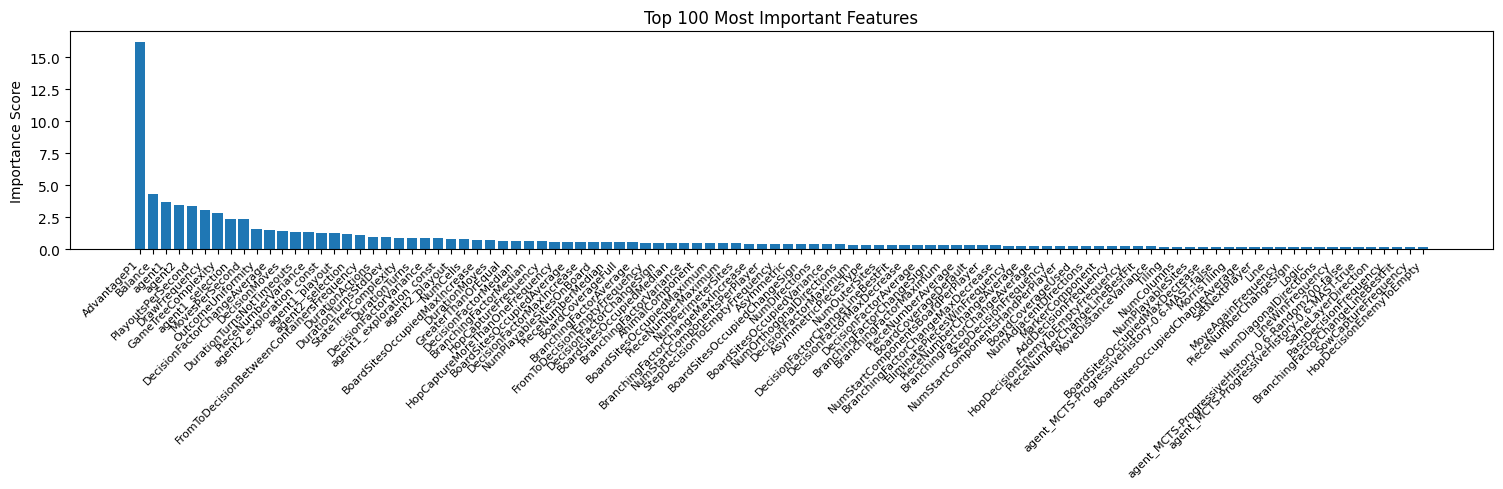

Fold 1 - RMSE: 0.4319361510152033
Fold 2


0:	learn: 0.6063134	test: 0.5721356	best: 0.5721356 (0)	total: 109ms	remaining: 5m 25s


50:	learn: 0.3884278	test: 0.4685570	best: 0.4685570 (50)	total: 5.93s	remaining: 5m 42s


100:	learn: 0.3497305	test: 0.4477287	best: 0.4477287 (100)	total: 12.1s	remaining: 5m 47s


150:	learn: 0.3273638	test: 0.4374408	best: 0.4374375 (149)	total: 18.1s	remaining: 5m 42s


200:	learn: 0.3107403	test: 0.4318715	best: 0.4318715 (200)	total: 24.1s	remaining: 5m 36s


250:	learn: 0.2981656	test: 0.4281620	best: 0.4281620 (250)	total: 30.2s	remaining: 5m 30s


300:	learn: 0.2892841	test: 0.4257730	best: 0.4257730 (300)	total: 36.4s	remaining: 5m 26s


350:	learn: 0.2806479	test: 0.4239754	best: 0.4239754 (350)	total: 42.5s	remaining: 5m 20s


400:	learn: 0.2733772	test: 0.4231141	best: 0.4231141 (400)	total: 48.6s	remaining: 5m 15s


450:	learn: 0.2673073	test: 0.4213134	best: 0.4213134 (450)	total: 54.9s	remaining: 5m 10s


500:	learn: 0.2617031	test: 0.4199541	best: 0.4199468 (499)	total: 1m	remaining: 5m 4s


550:	learn: 0.2567659	test: 0.4194794	best: 0.4193631 (536)	total: 1m 7s	remaining: 4m 58s


600:	learn: 0.2526181	test: 0.4187640	best: 0.4187640 (600)	total: 1m 13s	remaining: 4m 52s


650:	learn: 0.2486128	test: 0.4187889	best: 0.4187428 (638)	total: 1m 19s	remaining: 4m 47s


700:	learn: 0.2446390	test: 0.4182408	best: 0.4182408 (700)	total: 1m 25s	remaining: 4m 41s


750:	learn: 0.2410475	test: 0.4179819	best: 0.4179699 (748)	total: 1m 31s	remaining: 4m 35s


800:	learn: 0.2379084	test: 0.4177192	best: 0.4177115 (799)	total: 1m 38s	remaining: 4m 29s


850:	learn: 0.2349863	test: 0.4174570	best: 0.4174518 (849)	total: 1m 44s	remaining: 4m 23s


900:	learn: 0.2319967	test: 0.4172430	best: 0.4170859 (896)	total: 1m 50s	remaining: 4m 17s


950:	learn: 0.2293921	test: 0.4169371	best: 0.4169000 (944)	total: 1m 56s	remaining: 4m 11s


1000:	learn: 0.2268315	test: 0.4167721	best: 0.4167515 (986)	total: 2m 3s	remaining: 4m 5s


1050:	learn: 0.2242167	test: 0.4166433	best: 0.4166433 (1050)	total: 2m 9s	remaining: 3m 59s


1100:	learn: 0.2218347	test: 0.4164705	best: 0.4164705 (1100)	total: 2m 15s	remaining: 3m 53s


1150:	learn: 0.2196138	test: 0.4161138	best: 0.4160946 (1143)	total: 2m 21s	remaining: 3m 47s


1200:	learn: 0.2175508	test: 0.4159994	best: 0.4159531 (1194)	total: 2m 28s	remaining: 3m 41s


1250:	learn: 0.2154918	test: 0.4159088	best: 0.4159019 (1222)	total: 2m 34s	remaining: 3m 35s


1300:	learn: 0.2134931	test: 0.4158978	best: 0.4158869 (1298)	total: 2m 40s	remaining: 3m 29s


1350:	learn: 0.2115413	test: 0.4158504	best: 0.4157873 (1336)	total: 2m 46s	remaining: 3m 23s


1400:	learn: 0.2097474	test: 0.4157779	best: 0.4157754 (1399)	total: 2m 53s	remaining: 3m 17s


1450:	learn: 0.2078337	test: 0.4155963	best: 0.4155841 (1449)	total: 2m 59s	remaining: 3m 11s


1500:	learn: 0.2060758	test: 0.4154040	best: 0.4154040 (1500)	total: 3m 5s	remaining: 3m 5s


1550:	learn: 0.2043583	test: 0.4153073	best: 0.4153034 (1536)	total: 3m 11s	remaining: 2m 58s


1600:	learn: 0.2027381	test: 0.4153567	best: 0.4153033 (1551)	total: 3m 17s	remaining: 2m 52s


1650:	learn: 0.2010672	test: 0.4152808	best: 0.4152284 (1642)	total: 3m 23s	remaining: 2m 46s


1700:	learn: 0.1994020	test: 0.4151985	best: 0.4151853 (1698)	total: 3m 30s	remaining: 2m 40s


1750:	learn: 0.1978614	test: 0.4151738	best: 0.4151368 (1727)	total: 3m 36s	remaining: 2m 34s


1800:	learn: 0.1964073	test: 0.4150461	best: 0.4150461 (1800)	total: 3m 42s	remaining: 2m 28s


1850:	learn: 0.1948103	test: 0.4151165	best: 0.4150461 (1800)	total: 3m 48s	remaining: 2m 21s


1900:	learn: 0.1933483	test: 0.4150958	best: 0.4150461 (1800)	total: 3m 54s	remaining: 2m 15s


1950:	learn: 0.1919992	test: 0.4150927	best: 0.4150404 (1912)	total: 4m 1s	remaining: 2m 9s


2000:	learn: 0.1905079	test: 0.4150773	best: 0.4150404 (1912)	total: 4m 7s	remaining: 2m 3s


2050:	learn: 0.1890694	test: 0.4150014	best: 0.4150014 (2050)	total: 4m 13s	remaining: 1m 57s


2100:	learn: 0.1877101	test: 0.4149886	best: 0.4149357 (2076)	total: 4m 19s	remaining: 1m 51s


2150:	learn: 0.1863640	test: 0.4149880	best: 0.4149357 (2076)	total: 4m 25s	remaining: 1m 44s


2200:	learn: 0.1850463	test: 0.4150202	best: 0.4149357 (2076)	total: 4m 32s	remaining: 1m 38s


2250:	learn: 0.1837737	test: 0.4150677	best: 0.4149357 (2076)	total: 4m 38s	remaining: 1m 32s


2300:	learn: 0.1825230	test: 0.4150339	best: 0.4149357 (2076)	total: 4m 45s	remaining: 1m 26s


2350:	learn: 0.1813305	test: 0.4150457	best: 0.4149357 (2076)	total: 4m 51s	remaining: 1m 20s


2400:	learn: 0.1799877	test: 0.4149949	best: 0.4149357 (2076)	total: 4m 58s	remaining: 1m 14s


2450:	learn: 0.1787766	test: 0.4149699	best: 0.4149357 (2076)	total: 5m 5s	remaining: 1m 8s


2500:	learn: 0.1775528	test: 0.4149595	best: 0.4149357 (2076)	total: 5m 11s	remaining: 1m 2s


2550:	learn: 0.1763572	test: 0.4149577	best: 0.4149357 (2076)	total: 5m 18s	remaining: 56s


2600:	learn: 0.1751327	test: 0.4149711	best: 0.4149357 (2076)	total: 5m 24s	remaining: 49.8s


2650:	learn: 0.1739953	test: 0.4149354	best: 0.4149294 (2647)	total: 5m 30s	remaining: 43.5s


2700:	learn: 0.1728385	test: 0.4149141	best: 0.4149007 (2676)	total: 5m 36s	remaining: 37.3s


2750:	learn: 0.1716876	test: 0.4148488	best: 0.4148439 (2737)	total: 5m 42s	remaining: 31s


2800:	learn: 0.1706646	test: 0.4148539	best: 0.4148436 (2756)	total: 5m 49s	remaining: 24.8s


2850:	learn: 0.1696007	test: 0.4148727	best: 0.4148436 (2756)	total: 5m 55s	remaining: 18.6s


2900:	learn: 0.1685577	test: 0.4148666	best: 0.4148291 (2892)	total: 6m 1s	remaining: 12.3s


2950:	learn: 0.1675460	test: 0.4148481	best: 0.4148291 (2892)	total: 6m 7s	remaining: 6.1s


2999:	learn: 0.1665500	test: 0.4148557	best: 0.4148291 (2892)	total: 6m 13s	remaining: 0us

bestTest = 0.4148290608
bestIteration = 2892

Shrink model to first 2893 iterations.


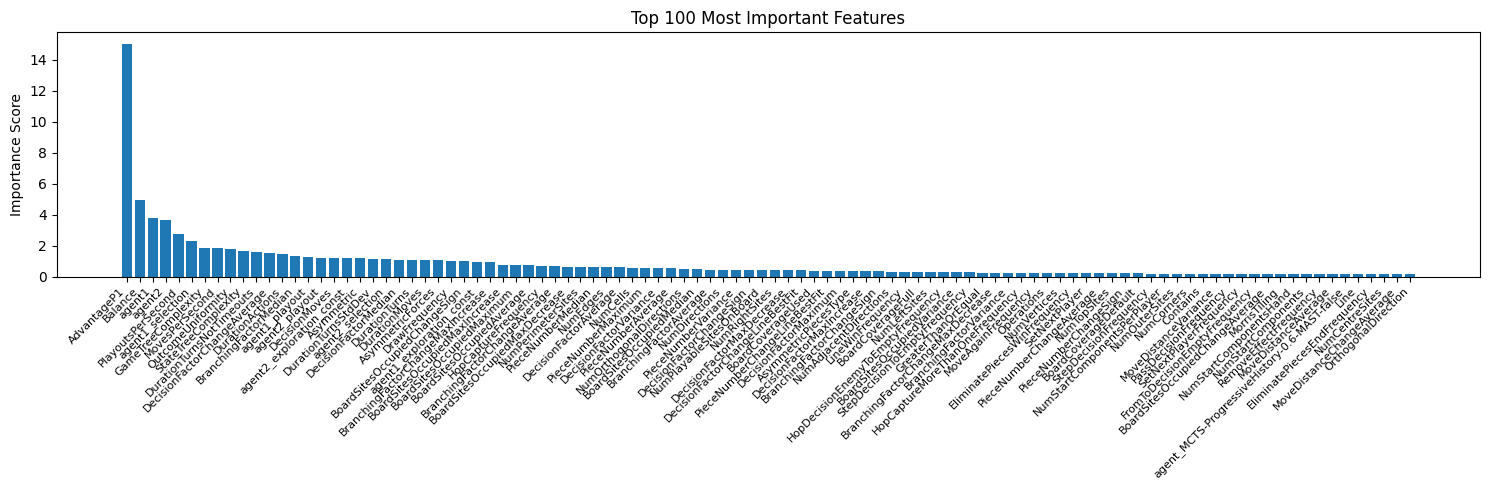

Fold 2 - RMSE: 0.41440538938219135
Fold 3


0:	learn: 0.6107245	test: 0.5714228	best: 0.5714228 (0)	total: 104ms	remaining: 5m 10s


50:	learn: 0.3884296	test: 0.4581182	best: 0.4581182 (50)	total: 5.81s	remaining: 5m 36s


100:	learn: 0.3481580	test: 0.4408638	best: 0.4408638 (100)	total: 11.7s	remaining: 5m 35s


150:	learn: 0.3255874	test: 0.4330991	best: 0.4330991 (150)	total: 17.6s	remaining: 5m 31s


200:	learn: 0.3100390	test: 0.4285396	best: 0.4285396 (200)	total: 23.5s	remaining: 5m 27s


250:	learn: 0.2984513	test: 0.4272576	best: 0.4271234 (236)	total: 29.5s	remaining: 5m 22s


300:	learn: 0.2883550	test: 0.4256290	best: 0.4256290 (300)	total: 35.4s	remaining: 5m 17s


350:	learn: 0.2799684	test: 0.4241181	best: 0.4241000 (349)	total: 41.3s	remaining: 5m 11s


400:	learn: 0.2728483	test: 0.4228203	best: 0.4228203 (400)	total: 47.2s	remaining: 5m 5s


450:	learn: 0.2666574	test: 0.4223251	best: 0.4223251 (450)	total: 53.2s	remaining: 5m


500:	learn: 0.2608553	test: 0.4216039	best: 0.4216039 (500)	total: 59.2s	remaining: 4m 55s


550:	learn: 0.2558010	test: 0.4212766	best: 0.4212064 (531)	total: 1m 5s	remaining: 4m 49s


600:	learn: 0.2513751	test: 0.4209377	best: 0.4208361 (594)	total: 1m 11s	remaining: 4m 45s


650:	learn: 0.2470286	test: 0.4205009	best: 0.4205009 (650)	total: 1m 17s	remaining: 4m 41s


700:	learn: 0.2432517	test: 0.4200248	best: 0.4200248 (700)	total: 1m 24s	remaining: 4m 35s


750:	learn: 0.2396908	test: 0.4198409	best: 0.4198407 (749)	total: 1m 30s	remaining: 4m 30s


800:	learn: 0.2363525	test: 0.4196013	best: 0.4195894 (796)	total: 1m 36s	remaining: 4m 24s


850:	learn: 0.2334327	test: 0.4194085	best: 0.4193331 (842)	total: 1m 42s	remaining: 4m 18s


900:	learn: 0.2307507	test: 0.4191292	best: 0.4191292 (900)	total: 1m 48s	remaining: 4m 12s


950:	learn: 0.2280713	test: 0.4189909	best: 0.4189788 (947)	total: 1m 54s	remaining: 4m 5s


1000:	learn: 0.2254029	test: 0.4190037	best: 0.4188977 (982)	total: 2m	remaining: 3m 59s


1050:	learn: 0.2228645	test: 0.4190129	best: 0.4188977 (982)	total: 2m 6s	remaining: 3m 53s


1100:	learn: 0.2203550	test: 0.4188850	best: 0.4188308 (1084)	total: 2m 11s	remaining: 3m 47s


1150:	learn: 0.2180619	test: 0.4188276	best: 0.4187615 (1120)	total: 2m 18s	remaining: 3m 41s


1200:	learn: 0.2159641	test: 0.4186638	best: 0.4186617 (1198)	total: 2m 24s	remaining: 3m 35s


1250:	learn: 0.2137801	test: 0.4185854	best: 0.4185787 (1248)	total: 2m 30s	remaining: 3m 29s


1300:	learn: 0.2117367	test: 0.4185402	best: 0.4185351 (1295)	total: 2m 36s	remaining: 3m 24s


1350:	learn: 0.2094879	test: 0.4182270	best: 0.4182168 (1349)	total: 2m 42s	remaining: 3m 18s


1400:	learn: 0.2075468	test: 0.4181995	best: 0.4181617 (1363)	total: 2m 49s	remaining: 3m 13s


1450:	learn: 0.2056949	test: 0.4180863	best: 0.4180731 (1447)	total: 2m 56s	remaining: 3m 8s


1500:	learn: 0.2039453	test: 0.4180152	best: 0.4180097 (1488)	total: 3m 3s	remaining: 3m 3s


1550:	learn: 0.2020854	test: 0.4180246	best: 0.4179669 (1534)	total: 3m 10s	remaining: 2m 57s


1600:	learn: 0.2001806	test: 0.4179244	best: 0.4179244 (1600)	total: 3m 16s	remaining: 2m 52s


1650:	learn: 0.1984741	test: 0.4178989	best: 0.4178615 (1626)	total: 3m 23s	remaining: 2m 46s


1700:	learn: 0.1966971	test: 0.4177981	best: 0.4177836 (1696)	total: 3m 29s	remaining: 2m 40s


1750:	learn: 0.1951493	test: 0.4177354	best: 0.4176821 (1736)	total: 3m 36s	remaining: 2m 34s


1800:	learn: 0.1936372	test: 0.4176778	best: 0.4176681 (1798)	total: 3m 42s	remaining: 2m 28s


1850:	learn: 0.1922484	test: 0.4176732	best: 0.4176293 (1835)	total: 3m 48s	remaining: 2m 22s


1900:	learn: 0.1904877	test: 0.4176663	best: 0.4176130 (1880)	total: 3m 55s	remaining: 2m 15s


1950:	learn: 0.1890277	test: 0.4175460	best: 0.4175460 (1950)	total: 4m 1s	remaining: 2m 9s


2000:	learn: 0.1876220	test: 0.4174629	best: 0.4174456 (1990)	total: 4m 7s	remaining: 2m 3s


2050:	learn: 0.1861617	test: 0.4174278	best: 0.4174195 (2017)	total: 4m 13s	remaining: 1m 57s


2100:	learn: 0.1847699	test: 0.4174823	best: 0.4174195 (2017)	total: 4m 20s	remaining: 1m 51s


2150:	learn: 0.1834161	test: 0.4174103	best: 0.4173755 (2141)	total: 4m 26s	remaining: 1m 45s


2200:	learn: 0.1820859	test: 0.4173073	best: 0.4173073 (2200)	total: 4m 32s	remaining: 1m 38s


2250:	learn: 0.1807604	test: 0.4173077	best: 0.4172806 (2235)	total: 4m 38s	remaining: 1m 32s


2300:	learn: 0.1793094	test: 0.4173617	best: 0.4172806 (2235)	total: 4m 45s	remaining: 1m 26s


2350:	learn: 0.1780130	test: 0.4174418	best: 0.4172806 (2235)	total: 4m 51s	remaining: 1m 20s


2400:	learn: 0.1768852	test: 0.4173718	best: 0.4172806 (2235)	total: 4m 58s	remaining: 1m 14s


2450:	learn: 0.1757124	test: 0.4173193	best: 0.4172806 (2235)	total: 5m 4s	remaining: 1m 8s


2500:	learn: 0.1746096	test: 0.4173046	best: 0.4172806 (2235)	total: 5m 10s	remaining: 1m 2s


2550:	learn: 0.1734742	test: 0.4172854	best: 0.4172798 (2514)	total: 5m 17s	remaining: 55.9s


2600:	learn: 0.1722404	test: 0.4172616	best: 0.4172467 (2588)	total: 5m 23s	remaining: 49.7s


2650:	learn: 0.1710353	test: 0.4172799	best: 0.4172467 (2588)	total: 5m 30s	remaining: 43.4s


2700:	learn: 0.1698745	test: 0.4173041	best: 0.4172467 (2588)	total: 5m 36s	remaining: 37.2s


2750:	learn: 0.1688209	test: 0.4172509	best: 0.4172463 (2746)	total: 5m 42s	remaining: 31s


2800:	learn: 0.1677194	test: 0.4172170	best: 0.4171966 (2766)	total: 5m 48s	remaining: 24.8s


2850:	learn: 0.1665076	test: 0.4171394	best: 0.4171348 (2846)	total: 5m 54s	remaining: 18.5s


2900:	learn: 0.1653922	test: 0.4171665	best: 0.4171345 (2851)	total: 6m	remaining: 12.3s


2950:	learn: 0.1643163	test: 0.4171773	best: 0.4171345 (2851)	total: 6m 6s	remaining: 6.09s


2999:	learn: 0.1633863	test: 0.4171089	best: 0.4171055 (2996)	total: 6m 13s	remaining: 0us

bestTest = 0.4171055417
bestIteration = 2996

Shrink model to first 2997 iterations.


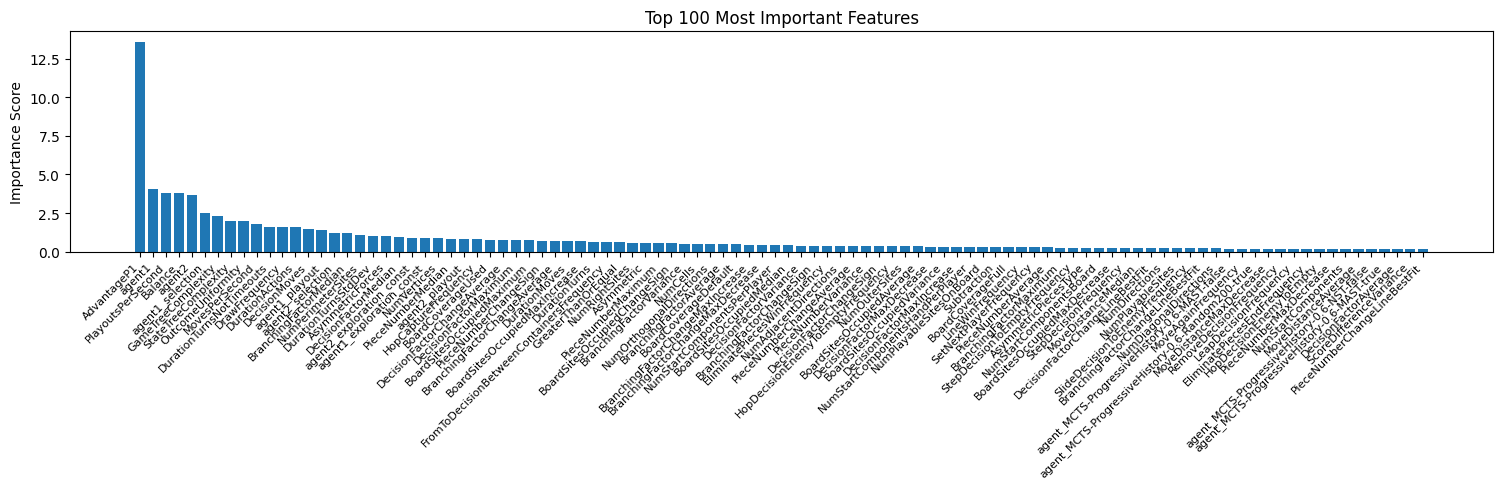

Fold 3 - RMSE: 0.4165904097602234
Fold 4


0:	learn: 0.6094943	test: 0.5661795	best: 0.5661795 (0)	total: 108ms	remaining: 5m 24s


50:	learn: 0.3889390	test: 0.4569392	best: 0.4569392 (50)	total: 6.14s	remaining: 5m 54s


100:	learn: 0.3488253	test: 0.4410920	best: 0.4410920 (100)	total: 12.4s	remaining: 5m 57s


150:	learn: 0.3257866	test: 0.4336778	best: 0.4336778 (150)	total: 18.6s	remaining: 5m 50s


200:	learn: 0.3105059	test: 0.4304192	best: 0.4304192 (200)	total: 24.7s	remaining: 5m 43s


250:	learn: 0.2975668	test: 0.4269493	best: 0.4268991 (249)	total: 30.7s	remaining: 5m 36s


300:	learn: 0.2879447	test: 0.4252087	best: 0.4252087 (300)	total: 36.8s	remaining: 5m 30s


350:	learn: 0.2802269	test: 0.4241045	best: 0.4240578 (349)	total: 43s	remaining: 5m 24s


400:	learn: 0.2731194	test: 0.4228144	best: 0.4228144 (400)	total: 49.1s	remaining: 5m 18s


450:	learn: 0.2672116	test: 0.4218996	best: 0.4218996 (450)	total: 55.9s	remaining: 5m 15s


500:	learn: 0.2618345	test: 0.4212073	best: 0.4212073 (500)	total: 1m 2s	remaining: 5m 10s


550:	learn: 0.2569360	test: 0.4208704	best: 0.4208704 (550)	total: 1m 8s	remaining: 5m 3s


600:	learn: 0.2526164	test: 0.4206628	best: 0.4205126 (588)	total: 1m 14s	remaining: 4m 57s


650:	learn: 0.2486905	test: 0.4202592	best: 0.4202592 (650)	total: 1m 20s	remaining: 4m 51s


700:	learn: 0.2448110	test: 0.4197520	best: 0.4197520 (700)	total: 1m 26s	remaining: 4m 45s


750:	learn: 0.2410971	test: 0.4196183	best: 0.4195998 (735)	total: 1m 33s	remaining: 4m 39s


800:	learn: 0.2380195	test: 0.4194151	best: 0.4193977 (775)	total: 1m 39s	remaining: 4m 33s


850:	learn: 0.2349278	test: 0.4192625	best: 0.4192625 (850)	total: 1m 45s	remaining: 4m 27s


900:	learn: 0.2318980	test: 0.4190998	best: 0.4190682 (892)	total: 1m 52s	remaining: 4m 21s


950:	learn: 0.2290093	test: 0.4190078	best: 0.4189743 (945)	total: 1m 58s	remaining: 4m 15s


1000:	learn: 0.2264733	test: 0.4188120	best: 0.4188120 (1000)	total: 2m 5s	remaining: 4m 11s


1050:	learn: 0.2242079	test: 0.4187284	best: 0.4187091 (1040)	total: 2m 12s	remaining: 4m 6s


1100:	learn: 0.2219313	test: 0.4185697	best: 0.4185451 (1092)	total: 2m 19s	remaining: 4m 1s


1150:	learn: 0.2199098	test: 0.4184795	best: 0.4184795 (1150)	total: 2m 26s	remaining: 3m 55s


1200:	learn: 0.2176272	test: 0.4181623	best: 0.4181405 (1193)	total: 2m 33s	remaining: 3m 50s


1250:	learn: 0.2155846	test: 0.4180620	best: 0.4180485 (1240)	total: 2m 40s	remaining: 3m 44s


1300:	learn: 0.2134795	test: 0.4178982	best: 0.4178766 (1296)	total: 2m 47s	remaining: 3m 38s


1350:	learn: 0.2115356	test: 0.4179432	best: 0.4178298 (1322)	total: 2m 54s	remaining: 3m 32s


1400:	learn: 0.2093935	test: 0.4179376	best: 0.4178298 (1322)	total: 3m 1s	remaining: 3m 26s


1450:	learn: 0.2077226	test: 0.4178874	best: 0.4178298 (1322)	total: 3m 8s	remaining: 3m 20s


1500:	learn: 0.2061444	test: 0.4179161	best: 0.4178298 (1322)	total: 3m 15s	remaining: 3m 15s


1550:	learn: 0.2045698	test: 0.4178955	best: 0.4178298 (1322)	total: 3m 22s	remaining: 3m 8s


1600:	learn: 0.2027923	test: 0.4178630	best: 0.4178298 (1322)	total: 3m 29s	remaining: 3m 2s


1650:	learn: 0.2011666	test: 0.4177361	best: 0.4177361 (1650)	total: 3m 36s	remaining: 2m 56s


1700:	learn: 0.1995303	test: 0.4176901	best: 0.4176676 (1686)	total: 3m 44s	remaining: 2m 51s


1750:	learn: 0.1980436	test: 0.4176551	best: 0.4176551 (1750)	total: 3m 51s	remaining: 2m 45s


1800:	learn: 0.1965739	test: 0.4177083	best: 0.4176424 (1758)	total: 3m 58s	remaining: 2m 38s


1850:	learn: 0.1952123	test: 0.4176598	best: 0.4176424 (1758)	total: 4m 5s	remaining: 2m 32s


1900:	learn: 0.1938157	test: 0.4176662	best: 0.4176143 (1874)	total: 4m 12s	remaining: 2m 26s


1950:	learn: 0.1921970	test: 0.4176360	best: 0.4176143 (1874)	total: 4m 19s	remaining: 2m 19s


2000:	learn: 0.1908236	test: 0.4176351	best: 0.4176143 (1874)	total: 4m 26s	remaining: 2m 13s


2050:	learn: 0.1892607	test: 0.4177066	best: 0.4176082 (2018)	total: 4m 33s	remaining: 2m 6s


2100:	learn: 0.1878097	test: 0.4175546	best: 0.4175316 (2090)	total: 4m 40s	remaining: 2m


2150:	learn: 0.1863759	test: 0.4174936	best: 0.4174936 (2150)	total: 4m 47s	remaining: 1m 53s


2200:	learn: 0.1849483	test: 0.4175080	best: 0.4174936 (2150)	total: 4m 54s	remaining: 1m 46s


2250:	learn: 0.1835884	test: 0.4173896	best: 0.4173896 (2250)	total: 5m 1s	remaining: 1m 40s


2300:	learn: 0.1822274	test: 0.4174086	best: 0.4173704 (2294)	total: 5m 8s	remaining: 1m 33s


2350:	learn: 0.1810332	test: 0.4174137	best: 0.4173704 (2294)	total: 5m 15s	remaining: 1m 27s


2400:	learn: 0.1797954	test: 0.4173479	best: 0.4173476 (2399)	total: 5m 22s	remaining: 1m 20s


2450:	learn: 0.1786006	test: 0.4173383	best: 0.4173380 (2449)	total: 5m 30s	remaining: 1m 13s


2500:	learn: 0.1773414	test: 0.4173425	best: 0.4172984 (2482)	total: 5m 37s	remaining: 1m 7s


2550:	learn: 0.1761806	test: 0.4173794	best: 0.4172984 (2482)	total: 5m 44s	remaining: 1m


2600:	learn: 0.1750668	test: 0.4173948	best: 0.4172984 (2482)	total: 5m 51s	remaining: 53.9s


2650:	learn: 0.1739733	test: 0.4173530	best: 0.4172984 (2482)	total: 5m 58s	remaining: 47.2s


2700:	learn: 0.1727784	test: 0.4173261	best: 0.4172984 (2482)	total: 6m 5s	remaining: 40.5s


2750:	learn: 0.1716935	test: 0.4173489	best: 0.4172984 (2482)	total: 6m 13s	remaining: 33.8s


2800:	learn: 0.1705957	test: 0.4173823	best: 0.4172984 (2482)	total: 6m 20s	remaining: 27s


2850:	learn: 0.1694333	test: 0.4173502	best: 0.4172984 (2482)	total: 6m 28s	remaining: 20.3s


2900:	learn: 0.1683133	test: 0.4173726	best: 0.4172984 (2482)	total: 6m 35s	remaining: 13.5s


2950:	learn: 0.1673080	test: 0.4173824	best: 0.4172984 (2482)	total: 6m 42s	remaining: 6.69s


2999:	learn: 0.1663350	test: 0.4174018	best: 0.4172984 (2482)	total: 6m 50s	remaining: 0us

bestTest = 0.4172983921
bestIteration = 2482

Shrink model to first 2483 iterations.


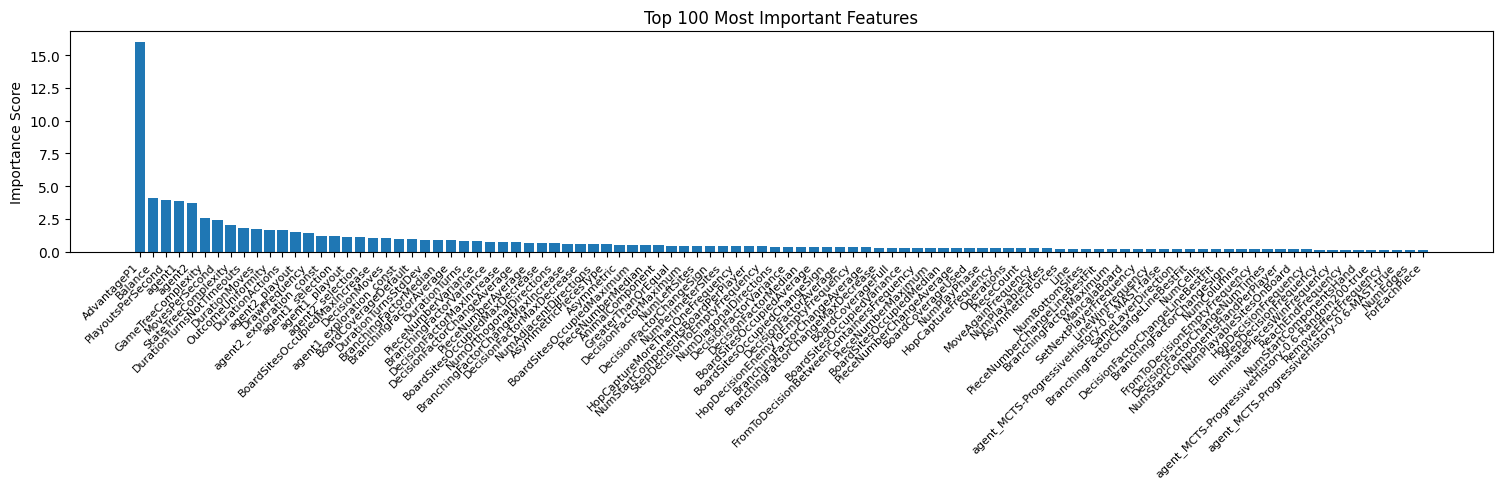

Fold 4 - RMSE: 0.41658059691005533
Fold 5


0:	learn: 0.6056299	test: 0.5774884	best: 0.5774884 (0)	total: 95.8ms	remaining: 4m 47s


50:	learn: 0.3857136	test: 0.4754716	best: 0.4754716 (50)	total: 7.42s	remaining: 7m 9s


100:	learn: 0.3490638	test: 0.4577105	best: 0.4577105 (100)	total: 15.1s	remaining: 7m 12s


150:	learn: 0.3272382	test: 0.4489671	best: 0.4489671 (150)	total: 22.7s	remaining: 7m 8s


200:	learn: 0.3114924	test: 0.4434135	best: 0.4434135 (200)	total: 30.2s	remaining: 7m


250:	learn: 0.3002810	test: 0.4404974	best: 0.4404974 (250)	total: 37.7s	remaining: 6m 52s


300:	learn: 0.2909865	test: 0.4387109	best: 0.4387109 (300)	total: 45.2s	remaining: 6m 45s


350:	learn: 0.2834056	test: 0.4376229	best: 0.4375712 (347)	total: 52.8s	remaining: 6m 38s


400:	learn: 0.2759833	test: 0.4355289	best: 0.4355289 (400)	total: 1m	remaining: 6m 31s


450:	learn: 0.2696847	test: 0.4345989	best: 0.4344859 (442)	total: 1m 7s	remaining: 6m 23s


500:	learn: 0.2640425	test: 0.4337809	best: 0.4337066 (498)	total: 1m 15s	remaining: 6m 16s


550:	learn: 0.2588053	test: 0.4330707	best: 0.4330271 (546)	total: 1m 22s	remaining: 6m 8s


600:	learn: 0.2542106	test: 0.4328317	best: 0.4328184 (590)	total: 1m 30s	remaining: 6m


650:	learn: 0.2495638	test: 0.4320467	best: 0.4319314 (647)	total: 1m 37s	remaining: 5m 52s


700:	learn: 0.2454964	test: 0.4316247	best: 0.4316247 (700)	total: 1m 45s	remaining: 5m 45s


750:	learn: 0.2419677	test: 0.4312907	best: 0.4312907 (750)	total: 1m 52s	remaining: 5m 37s


800:	learn: 0.2389120	test: 0.4309364	best: 0.4309364 (800)	total: 2m	remaining: 5m 29s


850:	learn: 0.2358727	test: 0.4305567	best: 0.4305566 (849)	total: 2m 7s	remaining: 5m 22s


900:	learn: 0.2328099	test: 0.4302992	best: 0.4302710 (887)	total: 2m 15s	remaining: 5m 14s


950:	learn: 0.2300003	test: 0.4302089	best: 0.4301904 (945)	total: 2m 22s	remaining: 5m 7s


1000:	learn: 0.2272930	test: 0.4299844	best: 0.4299844 (1000)	total: 2m 29s	remaining: 4m 59s


1050:	learn: 0.2249290	test: 0.4297978	best: 0.4297909 (1048)	total: 2m 37s	remaining: 4m 52s


1100:	learn: 0.2225341	test: 0.4297048	best: 0.4296642 (1070)	total: 2m 44s	remaining: 4m 44s


1150:	learn: 0.2202810	test: 0.4297262	best: 0.4296642 (1070)	total: 2m 52s	remaining: 4m 37s


1200:	learn: 0.2180598	test: 0.4295665	best: 0.4295198 (1193)	total: 3m	remaining: 4m 29s


1250:	learn: 0.2159763	test: 0.4293867	best: 0.4293782 (1227)	total: 3m 7s	remaining: 4m 22s


1300:	learn: 0.2139910	test: 0.4292703	best: 0.4292635 (1292)	total: 3m 14s	remaining: 4m 14s


1350:	learn: 0.2120473	test: 0.4292786	best: 0.4292397 (1320)	total: 3m 22s	remaining: 4m 6s


1400:	learn: 0.2101817	test: 0.4291634	best: 0.4291543 (1399)	total: 3m 29s	remaining: 3m 59s


1450:	learn: 0.2082802	test: 0.4291354	best: 0.4291059 (1449)	total: 3m 37s	remaining: 3m 51s


1500:	learn: 0.2066288	test: 0.4292203	best: 0.4291059 (1449)	total: 3m 44s	remaining: 3m 44s


1550:	learn: 0.2048728	test: 0.4292910	best: 0.4291059 (1449)	total: 3m 51s	remaining: 3m 36s


1600:	learn: 0.2031685	test: 0.4292423	best: 0.4291059 (1449)	total: 3m 59s	remaining: 3m 29s


1650:	learn: 0.2015618	test: 0.4292146	best: 0.4291059 (1449)	total: 4m 6s	remaining: 3m 21s


1700:	learn: 0.2001241	test: 0.4291540	best: 0.4291059 (1449)	total: 4m 14s	remaining: 3m 14s


1750:	learn: 0.1985857	test: 0.4290407	best: 0.4290221 (1746)	total: 4m 21s	remaining: 3m 6s


1800:	learn: 0.1970354	test: 0.4290391	best: 0.4290185 (1796)	total: 4m 28s	remaining: 2m 58s


1850:	learn: 0.1956957	test: 0.4289866	best: 0.4289704 (1847)	total: 4m 36s	remaining: 2m 51s


1900:	learn: 0.1942429	test: 0.4289445	best: 0.4289073 (1873)	total: 4m 43s	remaining: 2m 43s


1950:	learn: 0.1927410	test: 0.4288823	best: 0.4288630 (1943)	total: 4m 50s	remaining: 2m 36s


2000:	learn: 0.1913952	test: 0.4289415	best: 0.4288410 (1964)	total: 4m 58s	remaining: 2m 28s


2050:	learn: 0.1899073	test: 0.4289868	best: 0.4288410 (1964)	total: 5m 5s	remaining: 2m 21s


2100:	learn: 0.1884921	test: 0.4289001	best: 0.4288410 (1964)	total: 5m 12s	remaining: 2m 13s


2150:	learn: 0.1871011	test: 0.4289082	best: 0.4288410 (1964)	total: 5m 20s	remaining: 2m 6s


2200:	learn: 0.1857564	test: 0.4289434	best: 0.4288410 (1964)	total: 5m 27s	remaining: 1m 58s


2250:	learn: 0.1844485	test: 0.4288773	best: 0.4288410 (1964)	total: 5m 34s	remaining: 1m 51s


2300:	learn: 0.1831878	test: 0.4289082	best: 0.4288410 (1964)	total: 5m 41s	remaining: 1m 43s


2350:	learn: 0.1819707	test: 0.4289200	best: 0.4288410 (1964)	total: 5m 49s	remaining: 1m 36s


2400:	learn: 0.1807730	test: 0.4289732	best: 0.4288410 (1964)	total: 5m 56s	remaining: 1m 28s


2450:	learn: 0.1795882	test: 0.4288950	best: 0.4288410 (1964)	total: 6m 4s	remaining: 1m 21s


2500:	learn: 0.1782805	test: 0.4289365	best: 0.4288410 (1964)	total: 6m 11s	remaining: 1m 14s


2550:	learn: 0.1771642	test: 0.4290479	best: 0.4288410 (1964)	total: 6m 18s	remaining: 1m 6s


2600:	learn: 0.1761092	test: 0.4290422	best: 0.4288410 (1964)	total: 6m 26s	remaining: 59.2s


2650:	learn: 0.1749087	test: 0.4290444	best: 0.4288410 (1964)	total: 6m 33s	remaining: 51.8s


2700:	learn: 0.1737729	test: 0.4290124	best: 0.4288410 (1964)	total: 6m 40s	remaining: 44.3s


2750:	learn: 0.1726655	test: 0.4289700	best: 0.4288410 (1964)	total: 6m 47s	remaining: 36.9s


2800:	learn: 0.1715711	test: 0.4290003	best: 0.4288410 (1964)	total: 6m 55s	remaining: 29.5s


2850:	learn: 0.1704906	test: 0.4290697	best: 0.4288410 (1964)	total: 7m 2s	remaining: 22.1s


2900:	learn: 0.1693405	test: 0.4290449	best: 0.4288410 (1964)	total: 7m 9s	remaining: 14.7s


2950:	learn: 0.1681700	test: 0.4290232	best: 0.4288410 (1964)	total: 7m 17s	remaining: 7.26s


2999:	learn: 0.1671538	test: 0.4290419	best: 0.4288410 (1964)	total: 7m 24s	remaining: 0us

bestTest = 0.4288410126
bestIteration = 1964

Shrink model to first 1965 iterations.


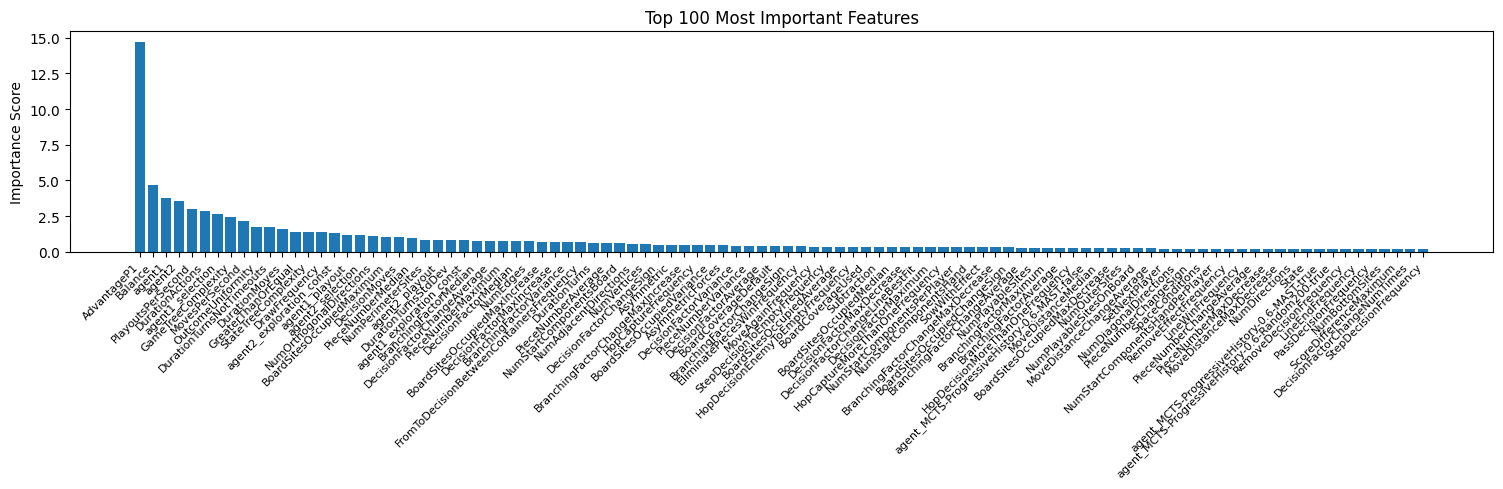

Fold 5 - RMSE: 0.4282026218252801
List of oof scores: [0.4319361510152033, 0.41440538938219135, 0.4165904097602234, 0.41658059691005533, 0.4282026218252801]
Average oof score: 0.4215430337785907


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_catboost_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")


CV1 OOF Scores:
Score: 0.4164
Score: 0.4385
Score: 0.4300
Score: 0.4388
Score: 0.4003
Average CV1 Score: 0.4248

CV2 OOF Scores:
Score: 0.4149
Score: 0.4012
Score: 0.4243
Score: 0.4402
Score: 0.4299
Average CV2 Score: 0.4221

CV3 OOF Scores:
Score: 0.4319
Score: 0.4144
Score: 0.4166
Score: 0.4166
Score: 0.4282
Average CV3 Score: 0.4215


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

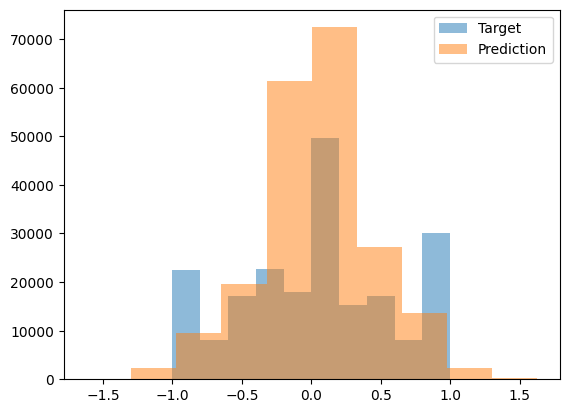

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler,
        include_position_features=True,
        include_text_features=True,
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        # data=test_processed[numerical_cols + categorical_cols + text_cols],
        data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols,
        # text_features=text_cols,
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.125618       │
│ 233235 ┆ -0.161821      │
│ 233236 ┆ -0.008901      │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'text_cols': text_cols,
    'encoder': encoder, 
    'scaler': scaler
}
with open(f'./catboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***